In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

from PIL import ImageEnhance
from skimage import data, exposure, img_as_float
from skimage.filters import gaussian

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
# rest_available = [11,12,50,51]
rest_available = [ 2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [5]:
p = "/gpfs/data/cbi/hcp/hcp_seg/data_manual_extract/train/1000_3/Data_orig/image100.mat"

In [6]:
i = sio.loadmat(p)['img']

In [7]:
i.shape

(1, 256, 287)

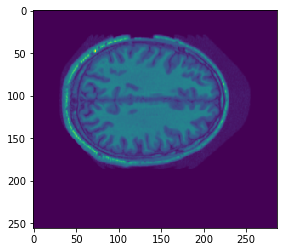

In [8]:
plt.imshow(i[0])

In [9]:
# import dipy
# import matplotlib.pylab as plt

# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [10]:
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [11]:


# m1 = x[88].reshape([256,256])
# m2 = x[94].reshape([256,256])

# plt.imshow(m1); plt.colorbar(); plt.show()
# plt.imshow(m2); plt.colorbar(); plt.show()

# regtools.overlay_images(m1, m2, 'channel1', 'channel2', 'both channels', 'tmp.png');
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

# mapping = sdr.optimize(m1, m2)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')
# warped_m2 = mapping.transform(m2, 'linear')

# regtools.overlay_images(m1, warped_m2, 'initial m1','Overlay','Warped m2', 'direct_warp_result.png')
# plt.imshow(warped_m2); plt.colorbar(); plt.show()

# plt.imshow(m1-warped_m2); plt.colorbar(); plt.show()
# plt.imshow(m1-m2); plt.colorbar(); plt.show()

In [5]:
num_seg = len(rest_available)+1

In [6]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [7]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-25,25))
        dy = np.round(random.uniform(-25,25))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        guassian_flag = random.random() > 0.5
        
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
        if self.train_data and guassian_flag:
            sigma_rand = random.uniform(0.65,1.0)
            im_sigma = gaussian(im, sigma = sigma_rand)
            gamma_rand = random.uniform(1.6,2.4)
            im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
            im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
        
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("all_complete_path.csv")

In [10]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
277*18

4986

In [12]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [13]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 12
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [14]:
data = next(iter(dataloader['train']))

In [15]:
data['y'].size()

torch.Size([12, 46, 256, 256])

In [16]:
data['x'].size()

torch.Size([12, 1, 256, 256])

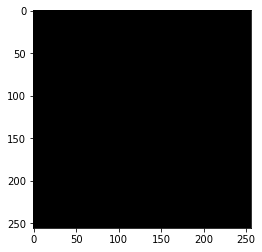

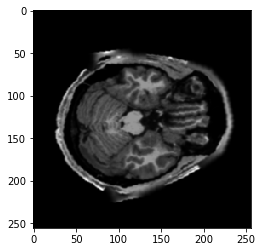

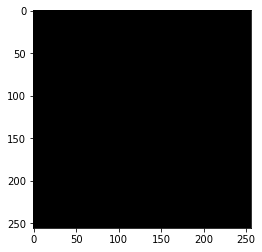

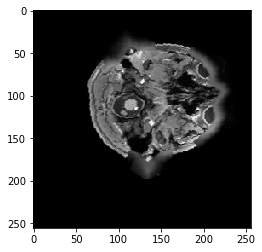

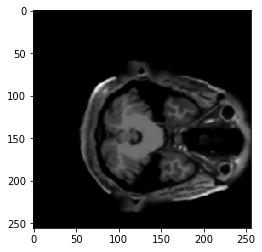

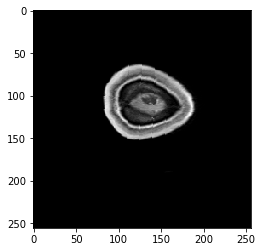

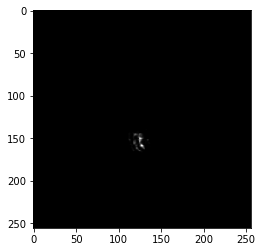

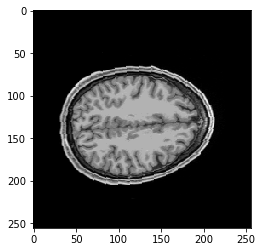

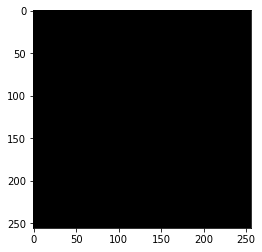

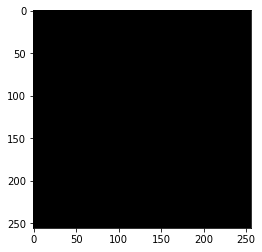

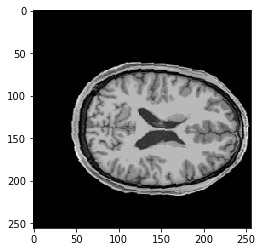

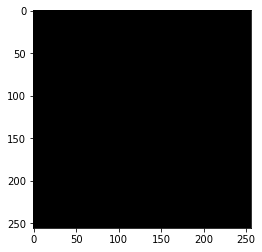

In [42]:
for i in range(bs):
    plt.imshow(data['x'][i,0,:,:],cmap='gray')
    plt.show()

In [25]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_46_seg')

In [17]:
class_wts = unpickling('new_class_wts_46_seg')

In [18]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [19]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [20]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [22]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [23]:
def get_gradient(true):
    true = true.data.cpu().numpy()
    N,C,sh1,sh2 = true.shape
    grads = []
    for i in range(N):
        grad_chan = []
        for j in range(C):
            sx = ndimage.sobel(true_out[i,j],axis=0,mode='constant')
            sy = ndimage.sobel(true_out[i,j],axis=1,mode='constant')
            sobel=np.hypot(sx,sy)
            grad_chan.append(sobel)
        grad_chan = np.vstack(grad_chan)
        grads.append(grad_chan)
    grads = np.vstack(grads)
    grads_mask = torch.from_numpy((np.absolute(grads)>0)).type(torch.cuda.FloatTensor)
    
    return grads_mask.view(N,C,-1)

In [24]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
    return 40*torch.mean(loss)+we*torch.mean(cel)
#     return torch.mean(loss)

In [25]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [26]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [27]:
model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [28]:
optimizer = optim.Adam(model.parameters(),lr = 1e-4)

In [29]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_1_both_dicencel_loss_lr_1e-4',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 1, Phase: train, epoch loss: 88.0973, Av. Dice Score: 0.4248
Class 0 (DS): 0.6307
Class 1 (DS): 0.4183
Class 2 (DS): 0.1582
Class 3 (DS): 0.1031
Class 4 (DS): 0.2866
Class 5 (DS): 0.4249
Class 6 (DS): 0.5808
Class 7 (DS): 0.3919
Class 8 (DS): 0.3662
Class 9 (DS): 0.7264
Class 10 (DS): 0.1842
Class 11 (DS): 0.2696
Class 12 (DS): 0.5451
Class 13 (DS): 0.6401
Class 14 (DS): 0.6015
Class 15 (DS): 0.1723
Class 16 (DS): 0.6238
Class 17 (DS): 0.5907
Class 18 (DS): 0.3283
Class 19 (DS): 0.2110
Class 20 (DS): 0.5390
Class 21 (DS): 0.5780
Class 22 (DS): 0.1089
Class 23 (DS): 0.4549
Class 24 (DS): 0.7497
Class 25 (DS): 0.3648
Class 26 (DS): 0.1987
Class 27 (DS): 0.1008
Class 28 (DS): 0.8809
Class 29 (DS): 0.7976
Class 30 (DS): 0.7889
Class 31 (DS): 0.8041
Class 32 (DS): 0.6081
Class 33 (DS): 0.4620
Class 34 (DS): 0.6248
Class 35 (DS): 0.0810
Class 36 (DS): 0.9880
Class 37 (DS): 0.0216
Class 38 (DS): 0.5249
Class 39 (DS): 0.1080
Class 40 (DS): 0.0678
Class 41 (DS): 0.0265
Class 42 (DS): 0.2

Epoch: 5, Phase: train, epoch loss: 56.0364, Av. Dice Score: 0.8654
Class 0 (DS): 0.7654
Class 1 (DS): 0.6923
Class 2 (DS): 0.8449
Class 3 (DS): 0.8979
Class 4 (DS): 0.8359
Class 5 (DS): 0.8112
Class 6 (DS): 0.9273
Class 7 (DS): 0.9213
Class 8 (DS): 0.9239
Class 9 (DS): 0.8710
Class 10 (DS): 0.8703
Class 11 (DS): 0.6822
Class 12 (DS): 0.8699
Class 13 (DS): 0.8713
Class 14 (DS): 0.9358
Class 15 (DS): 0.9098
Class 16 (DS): 0.9177
Class 17 (DS): 0.8972
Class 18 (DS): 0.9608
Class 19 (DS): 0.7840
Class 20 (DS): 0.7437
Class 21 (DS): 0.6745
Class 22 (DS): 0.7930
Class 23 (DS): 0.8611
Class 24 (DS): 0.8418
Class 25 (DS): 0.8346
Class 26 (DS): 0.9406
Class 27 (DS): 0.8972
Class 28 (DS): 0.9483
Class 29 (DS): 0.9220
Class 30 (DS): 0.8988
Class 31 (DS): 0.9371
Class 32 (DS): 0.9211
Class 33 (DS): 0.8976
Class 34 (DS): 0.9689
Class 35 (DS): 0.7791
Class 36 (DS): 0.9556
Class 37 (DS): 0.7092
Class 38 (DS): 0.8620
Class 39 (DS): 0.9031
Class 40 (DS): 0.9176
Class 41 (DS): 0.9168
Class 42 (DS): 0.8

Epoch: 9, Phase: train, epoch loss: 21.3373, Av. Dice Score: 0.9219
Class 0 (DS): 0.8965
Class 1 (DS): 0.8412
Class 2 (DS): 0.9586
Class 3 (DS): 0.9269
Class 4 (DS): 0.8964
Class 5 (DS): 0.9026
Class 6 (DS): 0.9514
Class 7 (DS): 0.9422
Class 8 (DS): 0.9484
Class 9 (DS): 0.9163
Class 10 (DS): 0.9139
Class 11 (DS): 0.8845
Class 12 (DS): 0.9236
Class 13 (DS): 0.9060
Class 14 (DS): 0.9527
Class 15 (DS): 0.9447
Class 16 (DS): 0.9449
Class 17 (DS): 0.9367
Class 18 (DS): 0.9781
Class 19 (DS): 0.8352
Class 20 (DS): 0.8943
Class 21 (DS): 0.8281
Class 22 (DS): 0.9387
Class 23 (DS): 0.9438
Class 24 (DS): 0.8959
Class 25 (DS): 0.9158
Class 26 (DS): 0.9568
Class 27 (DS): 0.9400
Class 28 (DS): 0.9536
Class 29 (DS): 0.9438
Class 30 (DS): 0.9244
Class 31 (DS): 0.9525
Class 32 (DS): 0.9516
Class 33 (DS): 0.9494
Class 34 (DS): 0.9752
Class 35 (DS): 0.8421
Class 36 (DS): 0.9625
Class 37 (DS): 0.8013
Class 38 (DS): 0.9369
Class 39 (DS): 0.9505
Class 40 (DS): 0.9544
Class 41 (DS): 0.9508
Class 42 (DS): 0.8

Epoch: 13, Phase: train, epoch loss: 18.1752, Av. Dice Score: 0.9278
Class 0 (DS): 0.9095
Class 1 (DS): 0.8613
Class 2 (DS): 0.9602
Class 3 (DS): 0.9320
Class 4 (DS): 0.9022
Class 5 (DS): 0.9114
Class 6 (DS): 0.9561
Class 7 (DS): 0.9477
Class 8 (DS): 0.9485
Class 9 (DS): 0.9298
Class 10 (DS): 0.9288
Class 11 (DS): 0.8935
Class 12 (DS): 0.9320
Class 13 (DS): 0.9180
Class 14 (DS): 0.9544
Class 15 (DS): 0.9480
Class 16 (DS): 0.9488
Class 17 (DS): 0.9416
Class 18 (DS): 0.9812
Class 19 (DS): 0.8482
Class 20 (DS): 0.9028
Class 21 (DS): 0.8504
Class 22 (DS): 0.9532
Class 23 (DS): 0.9507
Class 24 (DS): 0.9014
Class 25 (DS): 0.9229
Class 26 (DS): 0.9591
Class 27 (DS): 0.9422
Class 28 (DS): 0.9563
Class 29 (DS): 0.9431
Class 30 (DS): 0.9329
Class 31 (DS): 0.9533
Class 32 (DS): 0.9501
Class 33 (DS): 0.9490
Class 34 (DS): 0.9804
Class 35 (DS): 0.8479
Class 36 (DS): 0.9654
Class 37 (DS): 0.8068
Class 38 (DS): 0.9266
Class 39 (DS): 0.9544
Class 40 (DS): 0.9569
Class 41 (DS): 0.9525
Class 42 (DS): 0.

Epoch: 17, Phase: train, epoch loss: 17.1554, Av. Dice Score: 0.9302
Class 0 (DS): 0.9130
Class 1 (DS): 0.8668
Class 2 (DS): 0.9635
Class 3 (DS): 0.9338
Class 4 (DS): 0.8997
Class 5 (DS): 0.9236
Class 6 (DS): 0.9551
Class 7 (DS): 0.9483
Class 8 (DS): 0.9493
Class 9 (DS): 0.9288
Class 10 (DS): 0.9413
Class 11 (DS): 0.9017
Class 12 (DS): 0.9347
Class 13 (DS): 0.9225
Class 14 (DS): 0.9537
Class 15 (DS): 0.9502
Class 16 (DS): 0.9456
Class 17 (DS): 0.9506
Class 18 (DS): 0.9781
Class 19 (DS): 0.8470
Class 20 (DS): 0.9096
Class 21 (DS): 0.8650
Class 22 (DS): 0.9484
Class 23 (DS): 0.9531
Class 24 (DS): 0.8993
Class 25 (DS): 0.9231
Class 26 (DS): 0.9623
Class 27 (DS): 0.9433
Class 28 (DS): 0.9577
Class 29 (DS): 0.9491
Class 30 (DS): 0.9335
Class 31 (DS): 0.9547
Class 32 (DS): 0.9517
Class 33 (DS): 0.9519
Class 34 (DS): 0.9753
Class 35 (DS): 0.8422
Class 36 (DS): 0.9708
Class 37 (DS): 0.8129
Class 38 (DS): 0.9272
Class 39 (DS): 0.9642
Class 40 (DS): 0.9604
Class 41 (DS): 0.9549
Class 42 (DS): 0.

Epoch: 21, Phase: train, epoch loss: 15.9857, Av. Dice Score: 0.9331
Class 0 (DS): 0.9134
Class 1 (DS): 0.8675
Class 2 (DS): 0.9635
Class 3 (DS): 0.9365
Class 4 (DS): 0.9018
Class 5 (DS): 0.9194
Class 6 (DS): 0.9574
Class 7 (DS): 0.9496
Class 8 (DS): 0.9544
Class 9 (DS): 0.9316
Class 10 (DS): 0.9428
Class 11 (DS): 0.8977
Class 12 (DS): 0.9362
Class 13 (DS): 0.9310
Class 14 (DS): 0.9583
Class 15 (DS): 0.9527
Class 16 (DS): 0.9513
Class 17 (DS): 0.9497
Class 18 (DS): 0.9790
Class 19 (DS): 0.8505
Class 20 (DS): 0.9118
Class 21 (DS): 0.8707
Class 22 (DS): 0.9581
Class 23 (DS): 0.9576
Class 24 (DS): 0.9032
Class 25 (DS): 0.9255
Class 26 (DS): 0.9659
Class 27 (DS): 0.9449
Class 28 (DS): 0.9625
Class 29 (DS): 0.9466
Class 30 (DS): 0.9350
Class 31 (DS): 0.9584
Class 32 (DS): 0.9558
Class 33 (DS): 0.9513
Class 34 (DS): 0.9796
Class 35 (DS): 0.8495
Class 36 (DS): 0.9699
Class 37 (DS): 0.8148
Class 38 (DS): 0.9364
Class 39 (DS): 0.9661
Class 40 (DS): 0.9593
Class 41 (DS): 0.9583
Class 42 (DS): 0.

Epoch: 25, Phase: train, epoch loss: 15.9481, Av. Dice Score: 0.9327
Class 0 (DS): 0.9155
Class 1 (DS): 0.8607
Class 2 (DS): 0.9662
Class 3 (DS): 0.9456
Class 4 (DS): 0.9019
Class 5 (DS): 0.9208
Class 6 (DS): 0.9541
Class 7 (DS): 0.9475
Class 8 (DS): 0.9506
Class 9 (DS): 0.9367
Class 10 (DS): 0.9470
Class 11 (DS): 0.9054
Class 12 (DS): 0.9387
Class 13 (DS): 0.9340
Class 14 (DS): 0.9597
Class 15 (DS): 0.9517
Class 16 (DS): 0.9537
Class 17 (DS): 0.9535
Class 18 (DS): 0.9808
Class 19 (DS): 0.8525
Class 20 (DS): 0.9076
Class 21 (DS): 0.8674
Class 22 (DS): 0.9536
Class 23 (DS): 0.9594
Class 24 (DS): 0.9027
Class 25 (DS): 0.9232
Class 26 (DS): 0.9594
Class 27 (DS): 0.9458
Class 28 (DS): 0.9583
Class 29 (DS): 0.9457
Class 30 (DS): 0.9343
Class 31 (DS): 0.9588
Class 32 (DS): 0.9559
Class 33 (DS): 0.9541
Class 34 (DS): 0.9790
Class 35 (DS): 0.8464
Class 36 (DS): 0.9765
Class 37 (DS): 0.8063
Class 38 (DS): 0.9205
Class 39 (DS): 0.9680
Class 40 (DS): 0.9610
Class 41 (DS): 0.9615
Class 42 (DS): 0.

Epoch: 29, Phase: train, epoch loss: 14.7365, Av. Dice Score: 0.9375
Class 0 (DS): 0.9233
Class 1 (DS): 0.8810
Class 2 (DS): 0.9667
Class 3 (DS): 0.9443
Class 4 (DS): 0.9076
Class 5 (DS): 0.9361
Class 6 (DS): 0.9575
Class 7 (DS): 0.9511
Class 8 (DS): 0.9545
Class 9 (DS): 0.9384
Class 10 (DS): 0.9507
Class 11 (DS): 0.9126
Class 12 (DS): 0.9390
Class 13 (DS): 0.9382
Class 14 (DS): 0.9621
Class 15 (DS): 0.9537
Class 16 (DS): 0.9545
Class 17 (DS): 0.9574
Class 18 (DS): 0.9796
Class 19 (DS): 0.8524
Class 20 (DS): 0.9226
Class 21 (DS): 0.8827
Class 22 (DS): 0.9619
Class 23 (DS): 0.9625
Class 24 (DS): 0.9131
Class 25 (DS): 0.9317
Class 26 (DS): 0.9662
Class 27 (DS): 0.9451
Class 28 (DS): 0.9608
Class 29 (DS): 0.9526
Class 30 (DS): 0.9366
Class 31 (DS): 0.9615
Class 32 (DS): 0.9554
Class 33 (DS): 0.9568
Class 34 (DS): 0.9804
Class 35 (DS): 0.8527
Class 36 (DS): 0.9735
Class 37 (DS): 0.8175
Class 38 (DS): 0.9286
Class 39 (DS): 0.9691
Class 40 (DS): 0.9620
Class 41 (DS): 0.9637
Class 42 (DS): 0.

In [30]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [31]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_2_both_dicencel_lr_5e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 13.5871, Av. Dice Score: 0.9411
Class 0 (DS): 0.9255
Class 1 (DS): 0.8861
Class 2 (DS): 0.9703
Class 3 (DS): 0.9512
Class 4 (DS): 0.9106
Class 5 (DS): 0.9373
Class 6 (DS): 0.9620
Class 7 (DS): 0.9546
Class 8 (DS): 0.9590
Class 9 (DS): 0.9419
Class 10 (DS): 0.9519
Class 11 (DS): 0.9154
Class 12 (DS): 0.9434
Class 13 (DS): 0.9415
Class 14 (DS): 0.9625
Class 15 (DS): 0.9591
Class 16 (DS): 0.9578
Class 17 (DS): 0.9587
Class 18 (DS): 0.9805
Class 19 (DS): 0.8607
Class 20 (DS): 0.9226
Class 21 (DS): 0.8885
Class 22 (DS): 0.9652
Class 23 (DS): 0.9651
Class 24 (DS): 0.9151
Class 25 (DS): 0.9370
Class 26 (DS): 0.9658
Class 27 (DS): 0.9501
Class 28 (DS): 0.9642
Class 29 (DS): 0.9537
Class 30 (DS): 0.9439
Class 31 (DS): 0.9629
Class 32 (DS): 0.9607
Class 33 (DS): 0.9567
Class 34 (DS): 0.9833
Class 35 (DS): 0.8546
Class 36 (DS): 0.9760
Class 37 (DS): 0.8265
Class 38 (DS): 0.9388
Class 39 (DS): 0.9697
Class 40 (DS): 0.9650
Class 41 (DS): 0.9664
Class 42 (DS): 0.8

Epoch: 4, Phase: train, epoch loss: 12.8069, Av. Dice Score: 0.9441
Class 0 (DS): 0.9316
Class 1 (DS): 0.8914
Class 2 (DS): 0.9698
Class 3 (DS): 0.9550
Class 4 (DS): 0.9157
Class 5 (DS): 0.9367
Class 6 (DS): 0.9656
Class 7 (DS): 0.9586
Class 8 (DS): 0.9595
Class 9 (DS): 0.9451
Class 10 (DS): 0.9569
Class 11 (DS): 0.9192
Class 12 (DS): 0.9436
Class 13 (DS): 0.9465
Class 14 (DS): 0.9642
Class 15 (DS): 0.9612
Class 16 (DS): 0.9580
Class 17 (DS): 0.9604
Class 18 (DS): 0.9803
Class 19 (DS): 0.8712
Class 20 (DS): 0.9283
Class 21 (DS): 0.8917
Class 22 (DS): 0.9668
Class 23 (DS): 0.9658
Class 24 (DS): 0.9187
Class 25 (DS): 0.9410
Class 26 (DS): 0.9691
Class 27 (DS): 0.9513
Class 28 (DS): 0.9667
Class 29 (DS): 0.9567
Class 30 (DS): 0.9440
Class 31 (DS): 0.9641
Class 32 (DS): 0.9608
Class 33 (DS): 0.9614
Class 34 (DS): 0.9846
Class 35 (DS): 0.8592
Class 36 (DS): 0.9771
Class 37 (DS): 0.8391
Class 38 (DS): 0.9442
Class 39 (DS): 0.9695
Class 40 (DS): 0.9682
Class 41 (DS): 0.9673
Class 42 (DS): 0.8

Epoch: 8, Phase: train, epoch loss: 12.4666, Av. Dice Score: 0.9454
Class 0 (DS): 0.9322
Class 1 (DS): 0.8948
Class 2 (DS): 0.9714
Class 3 (DS): 0.9570
Class 4 (DS): 0.9162
Class 5 (DS): 0.9391
Class 6 (DS): 0.9634
Class 7 (DS): 0.9574
Class 8 (DS): 0.9604
Class 9 (DS): 0.9468
Class 10 (DS): 0.9583
Class 11 (DS): 0.9211
Class 12 (DS): 0.9486
Class 13 (DS): 0.9463
Class 14 (DS): 0.9677
Class 15 (DS): 0.9624
Class 16 (DS): 0.9592
Class 17 (DS): 0.9615
Class 18 (DS): 0.9844
Class 19 (DS): 0.8684
Class 20 (DS): 0.9288
Class 21 (DS): 0.8932
Class 22 (DS): 0.9666
Class 23 (DS): 0.9679
Class 24 (DS): 0.9175
Class 25 (DS): 0.9394
Class 26 (DS): 0.9701
Class 27 (DS): 0.9530
Class 28 (DS): 0.9671
Class 29 (DS): 0.9604
Class 30 (DS): 0.9427
Class 31 (DS): 0.9680
Class 32 (DS): 0.9611
Class 33 (DS): 0.9608
Class 34 (DS): 0.9832
Class 35 (DS): 0.8622
Class 36 (DS): 0.9782
Class 37 (DS): 0.8408
Class 38 (DS): 0.9470
Class 39 (DS): 0.9724
Class 40 (DS): 0.9700
Class 41 (DS): 0.9707
Class 42 (DS): 0.9

Epoch: 12, Phase: train, epoch loss: 12.0971, Av. Dice Score: 0.9470
Class 0 (DS): 0.9331
Class 1 (DS): 0.8963
Class 2 (DS): 0.9724
Class 3 (DS): 0.9588
Class 4 (DS): 0.9192
Class 5 (DS): 0.9413
Class 6 (DS): 0.9630
Class 7 (DS): 0.9607
Class 8 (DS): 0.9598
Class 9 (DS): 0.9471
Class 10 (DS): 0.9597
Class 11 (DS): 0.9261
Class 12 (DS): 0.9467
Class 13 (DS): 0.9505
Class 14 (DS): 0.9696
Class 15 (DS): 0.9616
Class 16 (DS): 0.9583
Class 17 (DS): 0.9621
Class 18 (DS): 0.9851
Class 19 (DS): 0.8695
Class 20 (DS): 0.9341
Class 21 (DS): 0.8937
Class 22 (DS): 0.9691
Class 23 (DS): 0.9693
Class 24 (DS): 0.9193
Class 25 (DS): 0.9402
Class 26 (DS): 0.9694
Class 27 (DS): 0.9557
Class 28 (DS): 0.9653
Class 29 (DS): 0.9595
Class 30 (DS): 0.9470
Class 31 (DS): 0.9678
Class 32 (DS): 0.9594
Class 33 (DS): 0.9603
Class 34 (DS): 0.9832
Class 35 (DS): 0.8651
Class 36 (DS): 0.9804
Class 37 (DS): 0.8459
Class 38 (DS): 0.9574
Class 39 (DS): 0.9739
Class 40 (DS): 0.9716
Class 41 (DS): 0.9717
Class 42 (DS): 0.

Epoch: 16, Phase: train, epoch loss: 11.6815, Av. Dice Score: 0.9481
Class 0 (DS): 0.9337
Class 1 (DS): 0.8945
Class 2 (DS): 0.9716
Class 3 (DS): 0.9632
Class 4 (DS): 0.9199
Class 5 (DS): 0.9410
Class 6 (DS): 0.9641
Class 7 (DS): 0.9601
Class 8 (DS): 0.9638
Class 9 (DS): 0.9456
Class 10 (DS): 0.9604
Class 11 (DS): 0.9282
Class 12 (DS): 0.9503
Class 13 (DS): 0.9484
Class 14 (DS): 0.9684
Class 15 (DS): 0.9655
Class 16 (DS): 0.9594
Class 17 (DS): 0.9633
Class 18 (DS): 0.9864
Class 19 (DS): 0.8721
Class 20 (DS): 0.9326
Class 21 (DS): 0.8918
Class 22 (DS): 0.9689
Class 23 (DS): 0.9732
Class 24 (DS): 0.9215
Class 25 (DS): 0.9449
Class 26 (DS): 0.9695
Class 27 (DS): 0.9540
Class 28 (DS): 0.9694
Class 29 (DS): 0.9569
Class 30 (DS): 0.9447
Class 31 (DS): 0.9675
Class 32 (DS): 0.9627
Class 33 (DS): 0.9596
Class 34 (DS): 0.9852
Class 35 (DS): 0.8669
Class 36 (DS): 0.9826
Class 37 (DS): 0.8519
Class 38 (DS): 0.9635
Class 39 (DS): 0.9704
Class 40 (DS): 0.9724
Class 41 (DS): 0.9762
Class 42 (DS): 0.

Epoch: 20, Phase: train, epoch loss: 11.6473, Av. Dice Score: 0.9483
Class 0 (DS): 0.9352
Class 1 (DS): 0.8980
Class 2 (DS): 0.9703
Class 3 (DS): 0.9639
Class 4 (DS): 0.9206
Class 5 (DS): 0.9416
Class 6 (DS): 0.9650
Class 7 (DS): 0.9597
Class 8 (DS): 0.9630
Class 9 (DS): 0.9466
Class 10 (DS): 0.9585
Class 11 (DS): 0.9280
Class 12 (DS): 0.9502
Class 13 (DS): 0.9484
Class 14 (DS): 0.9698
Class 15 (DS): 0.9622
Class 16 (DS): 0.9574
Class 17 (DS): 0.9611
Class 18 (DS): 0.9849
Class 19 (DS): 0.8694
Class 20 (DS): 0.9346
Class 21 (DS): 0.8991
Class 22 (DS): 0.9681
Class 23 (DS): 0.9712
Class 24 (DS): 0.9216
Class 25 (DS): 0.9410
Class 26 (DS): 0.9694
Class 27 (DS): 0.9566
Class 28 (DS): 0.9685
Class 29 (DS): 0.9563
Class 30 (DS): 0.9494
Class 31 (DS): 0.9695
Class 32 (DS): 0.9627
Class 33 (DS): 0.9613
Class 34 (DS): 0.9866
Class 35 (DS): 0.8715
Class 36 (DS): 0.9822
Class 37 (DS): 0.8484
Class 38 (DS): 0.9626
Class 39 (DS): 0.9754
Class 40 (DS): 0.9712
Class 41 (DS): 0.9748
Class 42 (DS): 0.

Epoch: 24, Phase: train, epoch loss: 11.2063, Av. Dice Score: 0.9502
Class 0 (DS): 0.9356
Class 1 (DS): 0.9024
Class 2 (DS): 0.9718
Class 3 (DS): 0.9660
Class 4 (DS): 0.9246
Class 5 (DS): 0.9410
Class 6 (DS): 0.9652
Class 7 (DS): 0.9609
Class 8 (DS): 0.9623
Class 9 (DS): 0.9503
Class 10 (DS): 0.9633
Class 11 (DS): 0.9314
Class 12 (DS): 0.9487
Class 13 (DS): 0.9492
Class 14 (DS): 0.9726
Class 15 (DS): 0.9647
Class 16 (DS): 0.9643
Class 17 (DS): 0.9630
Class 18 (DS): 0.9877
Class 19 (DS): 0.8733
Class 20 (DS): 0.9379
Class 21 (DS): 0.8983
Class 22 (DS): 0.9705
Class 23 (DS): 0.9714
Class 24 (DS): 0.9268
Class 25 (DS): 0.9447
Class 26 (DS): 0.9700
Class 27 (DS): 0.9544
Class 28 (DS): 0.9696
Class 29 (DS): 0.9591
Class 30 (DS): 0.9458
Class 31 (DS): 0.9685
Class 32 (DS): 0.9628
Class 33 (DS): 0.9610
Class 34 (DS): 0.9856
Class 35 (DS): 0.8683
Class 36 (DS): 0.9833
Class 37 (DS): 0.8544
Class 38 (DS): 0.9724
Class 39 (DS): 0.9754
Class 40 (DS): 0.9712
Class 41 (DS): 0.9733
Class 42 (DS): 0.

Epoch: 28, Phase: train, epoch loss: 10.9206, Av. Dice Score: 0.9514
Class 0 (DS): 0.9338
Class 1 (DS): 0.8992
Class 2 (DS): 0.9735
Class 3 (DS): 0.9672
Class 4 (DS): 0.9247
Class 5 (DS): 0.9429
Class 6 (DS): 0.9656
Class 7 (DS): 0.9625
Class 8 (DS): 0.9644
Class 9 (DS): 0.9525
Class 10 (DS): 0.9632
Class 11 (DS): 0.9325
Class 12 (DS): 0.9521
Class 13 (DS): 0.9519
Class 14 (DS): 0.9702
Class 15 (DS): 0.9652
Class 16 (DS): 0.9637
Class 17 (DS): 0.9654
Class 18 (DS): 0.9873
Class 19 (DS): 0.8791
Class 20 (DS): 0.9337
Class 21 (DS): 0.9019
Class 22 (DS): 0.9718
Class 23 (DS): 0.9715
Class 24 (DS): 0.9270
Class 25 (DS): 0.9440
Class 26 (DS): 0.9708
Class 27 (DS): 0.9575
Class 28 (DS): 0.9697
Class 29 (DS): 0.9602
Class 30 (DS): 0.9497
Class 31 (DS): 0.9715
Class 32 (DS): 0.9667
Class 33 (DS): 0.9640
Class 34 (DS): 0.9858
Class 35 (DS): 0.8745
Class 36 (DS): 0.9839
Class 37 (DS): 0.8596
Class 38 (DS): 0.9678
Class 39 (DS): 0.9739
Class 40 (DS): 0.9741
Class 41 (DS): 0.9768
Class 42 (DS): 0.

In [32]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [33]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_3_both_dicencel_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 10.2785, Av. Dice Score: 0.9542
Class 0 (DS): 0.9413
Class 1 (DS): 0.9065
Class 2 (DS): 0.9740
Class 3 (DS): 0.9692
Class 4 (DS): 0.9265
Class 5 (DS): 0.9445
Class 6 (DS): 0.9665
Class 7 (DS): 0.9636
Class 8 (DS): 0.9647
Class 9 (DS): 0.9534
Class 10 (DS): 0.9680
Class 11 (DS): 0.9383
Class 12 (DS): 0.9545
Class 13 (DS): 0.9546
Class 14 (DS): 0.9718
Class 15 (DS): 0.9664
Class 16 (DS): 0.9643
Class 17 (DS): 0.9671
Class 18 (DS): 0.9881
Class 19 (DS): 0.8842
Class 20 (DS): 0.9416
Class 21 (DS): 0.9077
Class 22 (DS): 0.9723
Class 23 (DS): 0.9746
Class 24 (DS): 0.9288
Class 25 (DS): 0.9484
Class 26 (DS): 0.9721
Class 27 (DS): 0.9571
Class 28 (DS): 0.9698
Class 29 (DS): 0.9607
Class 30 (DS): 0.9483
Class 31 (DS): 0.9708
Class 32 (DS): 0.9659
Class 33 (DS): 0.9678
Class 34 (DS): 0.9861
Class 35 (DS): 0.8795
Class 36 (DS): 0.9891
Class 37 (DS): 0.8647
Class 38 (DS): 0.9791
Class 39 (DS): 0.9786
Class 40 (DS): 0.9758
Class 41 (DS): 0.9774
Class 42 (DS): 0.9

Epoch: 4, Phase: train, epoch loss: 9.7249, Av. Dice Score: 0.9566
Class 0 (DS): 0.9433
Class 1 (DS): 0.9111
Class 2 (DS): 0.9724
Class 3 (DS): 0.9766
Class 4 (DS): 0.9294
Class 5 (DS): 0.9423
Class 6 (DS): 0.9683
Class 7 (DS): 0.9665
Class 8 (DS): 0.9669
Class 9 (DS): 0.9580
Class 10 (DS): 0.9704
Class 11 (DS): 0.9403
Class 12 (DS): 0.9540
Class 13 (DS): 0.9570
Class 14 (DS): 0.9758
Class 15 (DS): 0.9684
Class 16 (DS): 0.9647
Class 17 (DS): 0.9671
Class 18 (DS): 0.9894
Class 19 (DS): 0.8866
Class 20 (DS): 0.9416
Class 21 (DS): 0.9076
Class 22 (DS): 0.9730
Class 23 (DS): 0.9773
Class 24 (DS): 0.9330
Class 25 (DS): 0.9494
Class 26 (DS): 0.9725
Class 27 (DS): 0.9608
Class 28 (DS): 0.9714
Class 29 (DS): 0.9644
Class 30 (DS): 0.9517
Class 31 (DS): 0.9739
Class 32 (DS): 0.9676
Class 33 (DS): 0.9658
Class 34 (DS): 0.9890
Class 35 (DS): 0.8860
Class 36 (DS): 0.9901
Class 37 (DS): 0.8738
Class 38 (DS): 0.9831
Class 39 (DS): 0.9792
Class 40 (DS): 0.9778
Class 41 (DS): 0.9790
Class 42 (DS): 0.94

Epoch: 8, Phase: train, epoch loss: 9.7624, Av. Dice Score: 0.9566
Class 0 (DS): 0.9410
Class 1 (DS): 0.9094
Class 2 (DS): 0.9752
Class 3 (DS): 0.9782
Class 4 (DS): 0.9299
Class 5 (DS): 0.9402
Class 6 (DS): 0.9674
Class 7 (DS): 0.9658
Class 8 (DS): 0.9658
Class 9 (DS): 0.9575
Class 10 (DS): 0.9711
Class 11 (DS): 0.9375
Class 12 (DS): 0.9558
Class 13 (DS): 0.9589
Class 14 (DS): 0.9755
Class 15 (DS): 0.9672
Class 16 (DS): 0.9640
Class 17 (DS): 0.9660
Class 18 (DS): 0.9880
Class 19 (DS): 0.8913
Class 20 (DS): 0.9437
Class 21 (DS): 0.9108
Class 22 (DS): 0.9744
Class 23 (DS): 0.9788
Class 24 (DS): 0.9333
Class 25 (DS): 0.9482
Class 26 (DS): 0.9720
Class 27 (DS): 0.9595
Class 28 (DS): 0.9684
Class 29 (DS): 0.9652
Class 30 (DS): 0.9499
Class 31 (DS): 0.9755
Class 32 (DS): 0.9652
Class 33 (DS): 0.9682
Class 34 (DS): 0.9863
Class 35 (DS): 0.8865
Class 36 (DS): 0.9897
Class 37 (DS): 0.8727
Class 38 (DS): 0.9807
Class 39 (DS): 0.9796
Class 40 (DS): 0.9777
Class 41 (DS): 0.9814
Class 42 (DS): 0.93

Epoch: 12, Phase: train, epoch loss: 9.5310, Av. Dice Score: 0.9575
Class 0 (DS): 0.9425
Class 1 (DS): 0.9084
Class 2 (DS): 0.9764
Class 3 (DS): 0.9789
Class 4 (DS): 0.9314
Class 5 (DS): 0.9410
Class 6 (DS): 0.9682
Class 7 (DS): 0.9668
Class 8 (DS): 0.9668
Class 9 (DS): 0.9594
Class 10 (DS): 0.9701
Class 11 (DS): 0.9407
Class 12 (DS): 0.9543
Class 13 (DS): 0.9570
Class 14 (DS): 0.9750
Class 15 (DS): 0.9696
Class 16 (DS): 0.9676
Class 17 (DS): 0.9677
Class 18 (DS): 0.9904
Class 19 (DS): 0.8941
Class 20 (DS): 0.9422
Class 21 (DS): 0.9076
Class 22 (DS): 0.9744
Class 23 (DS): 0.9792
Class 24 (DS): 0.9321
Class 25 (DS): 0.9483
Class 26 (DS): 0.9731
Class 27 (DS): 0.9596
Class 28 (DS): 0.9722
Class 29 (DS): 0.9658
Class 30 (DS): 0.9540
Class 31 (DS): 0.9737
Class 32 (DS): 0.9682
Class 33 (DS): 0.9689
Class 34 (DS): 0.9880
Class 35 (DS): 0.8885
Class 36 (DS): 0.9907
Class 37 (DS): 0.8796
Class 38 (DS): 0.9817
Class 39 (DS): 0.9779
Class 40 (DS): 0.9804
Class 41 (DS): 0.9787
Class 42 (DS): 0.9

Epoch: 16, Phase: train, epoch loss: nan, Av. Dice Score: 0.7746
Class 0 (DS): 0.2617
Class 1 (DS): 0.1960
Class 2 (DS): 0.8000
Class 3 (DS): 0.9080
Class 4 (DS): 0.6973
Class 5 (DS): 0.5888
Class 6 (DS): 0.8379
Class 7 (DS): 0.7787
Class 8 (DS): 0.8185
Class 9 (DS): 0.8983
Class 10 (DS): 0.8446
Class 11 (DS): 0.7015
Class 12 (DS): 0.5453
Class 13 (DS): 0.7764
Class 14 (DS): 0.8727
Class 15 (DS): 0.8792
Class 16 (DS): 0.8995
Class 17 (DS): 0.8636
Class 18 (DS): 0.9733
Class 19 (DS): 0.7491
Class 20 (DS): 0.2509
Class 21 (DS): 0.1898
Class 22 (DS): 0.7923
Class 23 (DS): 0.9108
Class 24 (DS): 0.7005
Class 25 (DS): 0.5845
Class 26 (DS): 0.8407
Class 27 (DS): 0.7804
Class 28 (DS): 0.8215
Class 29 (DS): 0.9015
Class 30 (DS): 0.7709
Class 31 (DS): 0.8665
Class 32 (DS): 0.9060
Class 33 (DS): 0.8600
Class 34 (DS): 0.9712
Class 35 (DS): 0.7336
Class 36 (DS): 0.9888
Class 37 (DS): 0.7474
Class 38 (DS): 0.9600
Class 39 (DS): 0.9469
Class 40 (DS): 0.8678
Class 41 (DS): 0.9186
Class 42 (DS): 0.8992

Epoch: 20, Phase: train, epoch loss: nan, Av. Dice Score: 0.7706
Class 0 (DS): 0.2448
Class 1 (DS): 0.1760
Class 2 (DS): 0.7951
Class 3 (DS): 0.9105
Class 4 (DS): 0.6922
Class 5 (DS): 0.5835
Class 6 (DS): 0.8296
Class 7 (DS): 0.7729
Class 8 (DS): 0.8152
Class 9 (DS): 0.8955
Class 10 (DS): 0.8436
Class 11 (DS): 0.6983
Class 12 (DS): 0.5433
Class 13 (DS): 0.7751
Class 14 (DS): 0.8747
Class 15 (DS): 0.8773
Class 16 (DS): 0.8987
Class 17 (DS): 0.8617
Class 18 (DS): 0.9731
Class 19 (DS): 0.7421
Class 20 (DS): 0.2316
Class 21 (DS): 0.1698
Class 22 (DS): 0.7878
Class 23 (DS): 0.9122
Class 24 (DS): 0.6960
Class 25 (DS): 0.5792
Class 26 (DS): 0.8353
Class 27 (DS): 0.7761
Class 28 (DS): 0.8195
Class 29 (DS): 0.8990
Class 30 (DS): 0.7696
Class 31 (DS): 0.8682
Class 32 (DS): 0.9055
Class 33 (DS): 0.8581
Class 34 (DS): 0.9705
Class 35 (DS): 0.7271
Class 36 (DS): 0.9886
Class 37 (DS): 0.7433
Class 38 (DS): 0.9589
Class 39 (DS): 0.9483
Class 40 (DS): 0.8656
Class 41 (DS): 0.9156
Class 42 (DS): 0.8971

Epoch: 24, Phase: train, epoch loss: nan, Av. Dice Score: 0.7766
Class 0 (DS): 0.2640
Class 1 (DS): 0.1973
Class 2 (DS): 0.7979
Class 3 (DS): 0.9105
Class 4 (DS): 0.7048
Class 5 (DS): 0.5964
Class 6 (DS): 0.8342
Class 7 (DS): 0.7764
Class 8 (DS): 0.8202
Class 9 (DS): 0.8988
Class 10 (DS): 0.8494
Class 11 (DS): 0.7116
Class 12 (DS): 0.5512
Class 13 (DS): 0.7825
Class 14 (DS): 0.8789
Class 15 (DS): 0.8790
Class 16 (DS): 0.9019
Class 17 (DS): 0.8659
Class 18 (DS): 0.9744
Class 19 (DS): 0.7490
Class 20 (DS): 0.2531
Class 21 (DS): 0.1909
Class 22 (DS): 0.7905
Class 23 (DS): 0.9140
Class 24 (DS): 0.7099
Class 25 (DS): 0.5913
Class 26 (DS): 0.8391
Class 27 (DS): 0.7794
Class 28 (DS): 0.8238
Class 29 (DS): 0.9012
Class 30 (DS): 0.7773
Class 31 (DS): 0.8722
Class 32 (DS): 0.9079
Class 33 (DS): 0.8618
Class 34 (DS): 0.9718
Class 35 (DS): 0.7357
Class 36 (DS): 0.9883
Class 37 (DS): 0.7485
Class 38 (DS): 0.9576
Class 39 (DS): 0.9480
Class 40 (DS): 0.8662
Class 41 (DS): 0.9171
Class 42 (DS): 0.9008

Epoch: 28, Phase: train, epoch loss: nan, Av. Dice Score: 0.7731
Class 0 (DS): 0.2483
Class 1 (DS): 0.1817
Class 2 (DS): 0.7991
Class 3 (DS): 0.9114
Class 4 (DS): 0.6957
Class 5 (DS): 0.5870
Class 6 (DS): 0.8351
Class 7 (DS): 0.7768
Class 8 (DS): 0.8184
Class 9 (DS): 0.8965
Class 10 (DS): 0.8449
Class 11 (DS): 0.7027
Class 12 (DS): 0.5428
Class 13 (DS): 0.7773
Class 14 (DS): 0.8763
Class 15 (DS): 0.8801
Class 16 (DS): 0.9007
Class 17 (DS): 0.8649
Class 18 (DS): 0.9723
Class 19 (DS): 0.7466
Class 20 (DS): 0.2358
Class 21 (DS): 0.1756
Class 22 (DS): 0.7917
Class 23 (DS): 0.9127
Class 24 (DS): 0.6999
Class 25 (DS): 0.5821
Class 26 (DS): 0.8395
Class 27 (DS): 0.7795
Class 28 (DS): 0.8231
Class 29 (DS): 0.9004
Class 30 (DS): 0.7719
Class 31 (DS): 0.8698
Class 32 (DS): 0.9071
Class 33 (DS): 0.8603
Class 34 (DS): 0.9703
Class 35 (DS): 0.7338
Class 36 (DS): 0.9884
Class 37 (DS): 0.7446
Class 38 (DS): 0.9601
Class 39 (DS): 0.9482
Class 40 (DS): 0.8683
Class 41 (DS): 0.9172
Class 42 (DS): 0.8974

In [34]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [35]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_4_both_dicencel_lr_5e-6',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: nan, Av. Dice Score: 0.7718
Class 0 (DS): 0.2520
Class 1 (DS): 0.1876
Class 2 (DS): 0.7976
Class 3 (DS): 0.9072
Class 4 (DS): 0.6945
Class 5 (DS): 0.5861
Class 6 (DS): 0.8364
Class 7 (DS): 0.7749
Class 8 (DS): 0.8169
Class 9 (DS): 0.8951
Class 10 (DS): 0.8408
Class 11 (DS): 0.7019
Class 12 (DS): 0.5415
Class 13 (DS): 0.7718
Class 14 (DS): 0.8713
Class 15 (DS): 0.8819
Class 16 (DS): 0.8961
Class 17 (DS): 0.8577
Class 18 (DS): 0.9716
Class 19 (DS): 0.7439
Class 20 (DS): 0.2411
Class 21 (DS): 0.1796
Class 22 (DS): 0.7897
Class 23 (DS): 0.9073
Class 24 (DS): 0.6989
Class 25 (DS): 0.5804
Class 26 (DS): 0.8399
Class 27 (DS): 0.7781
Class 28 (DS): 0.8213
Class 29 (DS): 0.8993
Class 30 (DS): 0.7659
Class 31 (DS): 0.8636
Class 32 (DS): 0.9021
Class 33 (DS): 0.8543
Class 34 (DS): 0.9699
Class 35 (DS): 0.7296
Class 36 (DS): 0.9882
Class 37 (DS): 0.7466
Class 38 (DS): 0.9609
Class 39 (DS): 0.9463
Class 40 (DS): 0.8681
Class 41 (DS): 0.9153
Class 42 (DS): 0.8990


Epoch: 4, Phase: train, epoch loss: nan, Av. Dice Score: 0.7718
Class 0 (DS): 0.2549
Class 1 (DS): 0.1890
Class 2 (DS): 0.7945
Class 3 (DS): 0.9116
Class 4 (DS): 0.6956
Class 5 (DS): 0.5859
Class 6 (DS): 0.8320
Class 7 (DS): 0.7727
Class 8 (DS): 0.8150
Class 9 (DS): 0.8960
Class 10 (DS): 0.8419
Class 11 (DS): 0.7014
Class 12 (DS): 0.5423
Class 13 (DS): 0.7762
Class 14 (DS): 0.8743
Class 15 (DS): 0.8766
Class 16 (DS): 0.8987
Class 17 (DS): 0.8625
Class 18 (DS): 0.9722
Class 19 (DS): 0.7442
Class 20 (DS): 0.2431
Class 21 (DS): 0.1837
Class 22 (DS): 0.7854
Class 23 (DS): 0.9133
Class 24 (DS): 0.7003
Class 25 (DS): 0.5817
Class 26 (DS): 0.8354
Class 27 (DS): 0.7748
Class 28 (DS): 0.8192
Class 29 (DS): 0.8986
Class 30 (DS): 0.7683
Class 31 (DS): 0.8674
Class 32 (DS): 0.9050
Class 33 (DS): 0.8588
Class 34 (DS): 0.9710
Class 35 (DS): 0.7280
Class 36 (DS): 0.9887
Class 37 (DS): 0.7396
Class 38 (DS): 0.9573
Class 39 (DS): 0.9496
Class 40 (DS): 0.8642
Class 41 (DS): 0.9153
Class 42 (DS): 0.8975


Epoch: 8, Phase: train, epoch loss: nan, Av. Dice Score: 0.7737
Class 0 (DS): 0.2600
Class 1 (DS): 0.1927
Class 2 (DS): 0.8020
Class 3 (DS): 0.9082
Class 4 (DS): 0.6915
Class 5 (DS): 0.5822
Class 6 (DS): 0.8375
Class 7 (DS): 0.7780
Class 8 (DS): 0.8188
Class 9 (DS): 0.8968
Class 10 (DS): 0.8434
Class 11 (DS): 0.6995
Class 12 (DS): 0.5395
Class 13 (DS): 0.7753
Class 14 (DS): 0.8733
Class 15 (DS): 0.8826
Class 16 (DS): 0.8986
Class 17 (DS): 0.8612
Class 18 (DS): 0.9706
Class 19 (DS): 0.7485
Class 20 (DS): 0.2496
Class 21 (DS): 0.1867
Class 22 (DS): 0.7943
Class 23 (DS): 0.9132
Class 24 (DS): 0.6967
Class 25 (DS): 0.5764
Class 26 (DS): 0.8414
Class 27 (DS): 0.7835
Class 28 (DS): 0.8218
Class 29 (DS): 0.9009
Class 30 (DS): 0.7694
Class 31 (DS): 0.8661
Class 32 (DS): 0.9046
Class 33 (DS): 0.8566
Class 34 (DS): 0.9694
Class 35 (DS): 0.7327
Class 36 (DS): 0.9884
Class 37 (DS): 0.7501
Class 38 (DS): 0.9603
Class 39 (DS): 0.9486
Class 40 (DS): 0.8694
Class 41 (DS): 0.9181
Class 42 (DS): 0.9008


Epoch: 12, Phase: train, epoch loss: nan, Av. Dice Score: 0.7733
Class 0 (DS): 0.2584
Class 1 (DS): 0.1889
Class 2 (DS): 0.7948
Class 3 (DS): 0.9121
Class 4 (DS): 0.6947
Class 5 (DS): 0.5858
Class 6 (DS): 0.8328
Class 7 (DS): 0.7744
Class 8 (DS): 0.8174
Class 9 (DS): 0.8971
Class 10 (DS): 0.8459
Class 11 (DS): 0.7008
Class 12 (DS): 0.5441
Class 13 (DS): 0.7785
Class 14 (DS): 0.8773
Class 15 (DS): 0.8782
Class 16 (DS): 0.8999
Class 17 (DS): 0.8649
Class 18 (DS): 0.9729
Class 19 (DS): 0.7486
Class 20 (DS): 0.2480
Class 21 (DS): 0.1837
Class 22 (DS): 0.7884
Class 23 (DS): 0.9116
Class 24 (DS): 0.6986
Class 25 (DS): 0.5812
Class 26 (DS): 0.8349
Class 27 (DS): 0.7773
Class 28 (DS): 0.8211
Class 29 (DS): 0.8990
Class 30 (DS): 0.7731
Class 31 (DS): 0.8709
Class 32 (DS): 0.9068
Class 33 (DS): 0.8614
Class 34 (DS): 0.9714
Class 35 (DS): 0.7320
Class 36 (DS): 0.9874
Class 37 (DS): 0.7423
Class 38 (DS): 0.9587
Class 39 (DS): 0.9494
Class 40 (DS): 0.8677
Class 41 (DS): 0.9181
Class 42 (DS): 0.8975

Epoch: 16, Phase: train, epoch loss: nan, Av. Dice Score: 0.7731
Class 0 (DS): 0.2560
Class 1 (DS): 0.1880
Class 2 (DS): 0.7980
Class 3 (DS): 0.9093
Class 4 (DS): 0.6955
Class 5 (DS): 0.5872
Class 6 (DS): 0.8332
Class 7 (DS): 0.7777
Class 8 (DS): 0.8163
Class 9 (DS): 0.8961
Class 10 (DS): 0.8439
Class 11 (DS): 0.7011
Class 12 (DS): 0.5438
Class 13 (DS): 0.7738
Class 14 (DS): 0.8731
Class 15 (DS): 0.8757
Class 16 (DS): 0.9002
Class 17 (DS): 0.8653
Class 18 (DS): 0.9730
Class 19 (DS): 0.7450
Class 20 (DS): 0.2445
Class 21 (DS): 0.1816
Class 22 (DS): 0.7895
Class 23 (DS): 0.9113
Class 24 (DS): 0.7003
Class 25 (DS): 0.5830
Class 26 (DS): 0.8371
Class 27 (DS): 0.7785
Class 28 (DS): 0.8207
Class 29 (DS): 0.8992
Class 30 (DS): 0.7690
Class 31 (DS): 0.8670
Class 32 (DS): 0.9072
Class 33 (DS): 0.8612
Class 34 (DS): 0.9712
Class 35 (DS): 0.7317
Class 36 (DS): 0.9883
Class 37 (DS): 0.7454
Class 38 (DS): 0.9586
Class 39 (DS): 0.9480
Class 40 (DS): 0.8684
Class 41 (DS): 0.9211
Class 42 (DS): 0.9001

Epoch: 20, Phase: train, epoch loss: nan, Av. Dice Score: 0.7736
Class 0 (DS): 0.2568
Class 1 (DS): 0.1889
Class 2 (DS): 0.7989
Class 3 (DS): 0.9111
Class 4 (DS): 0.6951
Class 5 (DS): 0.5855
Class 6 (DS): 0.8344
Class 7 (DS): 0.7772
Class 8 (DS): 0.8169
Class 9 (DS): 0.8974
Class 10 (DS): 0.8455
Class 11 (DS): 0.7018
Class 12 (DS): 0.5434
Class 13 (DS): 0.7789
Class 14 (DS): 0.8764
Class 15 (DS): 0.8791
Class 16 (DS): 0.8987
Class 17 (DS): 0.8635
Class 18 (DS): 0.9725
Class 19 (DS): 0.7452
Class 20 (DS): 0.2449
Class 21 (DS): 0.1828
Class 22 (DS): 0.7924
Class 23 (DS): 0.9134
Class 24 (DS): 0.6980
Class 25 (DS): 0.5819
Class 26 (DS): 0.8377
Class 27 (DS): 0.7809
Class 28 (DS): 0.8209
Class 29 (DS): 0.9012
Class 30 (DS): 0.7724
Class 31 (DS): 0.8693
Class 32 (DS): 0.9057
Class 33 (DS): 0.8592
Class 34 (DS): 0.9697
Class 35 (DS): 0.7307
Class 36 (DS): 0.9887
Class 37 (DS): 0.7481
Class 38 (DS): 0.9590
Class 39 (DS): 0.9499
Class 40 (DS): 0.8671
Class 41 (DS): 0.9184
Class 42 (DS): 0.8984

Epoch: 24, Phase: train, epoch loss: nan, Av. Dice Score: 0.7777
Class 0 (DS): 0.2694
Class 1 (DS): 0.2018
Class 2 (DS): 0.8023
Class 3 (DS): 0.9130
Class 4 (DS): 0.6998
Class 5 (DS): 0.5921
Class 6 (DS): 0.8406
Class 7 (DS): 0.7808
Class 8 (DS): 0.8217
Class 9 (DS): 0.8996
Class 10 (DS): 0.8476
Class 11 (DS): 0.7062
Class 12 (DS): 0.5524
Class 13 (DS): 0.7801
Class 14 (DS): 0.8762
Class 15 (DS): 0.8836
Class 16 (DS): 0.9018
Class 17 (DS): 0.8666
Class 18 (DS): 0.9726
Class 19 (DS): 0.7537
Class 20 (DS): 0.2576
Class 21 (DS): 0.1954
Class 22 (DS): 0.7945
Class 23 (DS): 0.9153
Class 24 (DS): 0.7045
Class 25 (DS): 0.5876
Class 26 (DS): 0.8430
Class 27 (DS): 0.7852
Class 28 (DS): 0.8254
Class 29 (DS): 0.9034
Class 30 (DS): 0.7752
Class 31 (DS): 0.8683
Class 32 (DS): 0.9075
Class 33 (DS): 0.8629
Class 34 (DS): 0.9710
Class 35 (DS): 0.7385
Class 36 (DS): 0.9888
Class 37 (DS): 0.7502
Class 38 (DS): 0.9592
Class 39 (DS): 0.9510
Class 40 (DS): 0.8705
Class 41 (DS): 0.9183
Class 42 (DS): 0.9004

Epoch: 28, Phase: train, epoch loss: nan, Av. Dice Score: 0.7726
Class 0 (DS): 0.2536
Class 1 (DS): 0.1868
Class 2 (DS): 0.8005
Class 3 (DS): 0.9094
Class 4 (DS): 0.6905
Class 5 (DS): 0.5826
Class 6 (DS): 0.8335
Class 7 (DS): 0.7786
Class 8 (DS): 0.8162
Class 9 (DS): 0.8969
Class 10 (DS): 0.8419
Class 11 (DS): 0.6961
Class 12 (DS): 0.5419
Class 13 (DS): 0.7746
Class 14 (DS): 0.8733
Class 15 (DS): 0.8797
Class 16 (DS): 0.8989
Class 17 (DS): 0.8619
Class 18 (DS): 0.9723
Class 19 (DS): 0.7462
Class 20 (DS): 0.2428
Class 21 (DS): 0.1798
Class 22 (DS): 0.7915
Class 23 (DS): 0.9136
Class 24 (DS): 0.6959
Class 25 (DS): 0.5777
Class 26 (DS): 0.8372
Class 27 (DS): 0.7815
Class 28 (DS): 0.8204
Class 29 (DS): 0.8998
Class 30 (DS): 0.7700
Class 31 (DS): 0.8675
Class 32 (DS): 0.9052
Class 33 (DS): 0.8577
Class 34 (DS): 0.9709
Class 35 (DS): 0.7307
Class 36 (DS): 0.9888
Class 37 (DS): 0.7501
Class 38 (DS): 0.9594
Class 39 (DS): 0.9471
Class 40 (DS): 0.8689
Class 41 (DS): 0.9198
Class 42 (DS): 0.9011

In [36]:
#most recent model
#guassian_gamma_v1_4

In [37]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [38]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [39]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


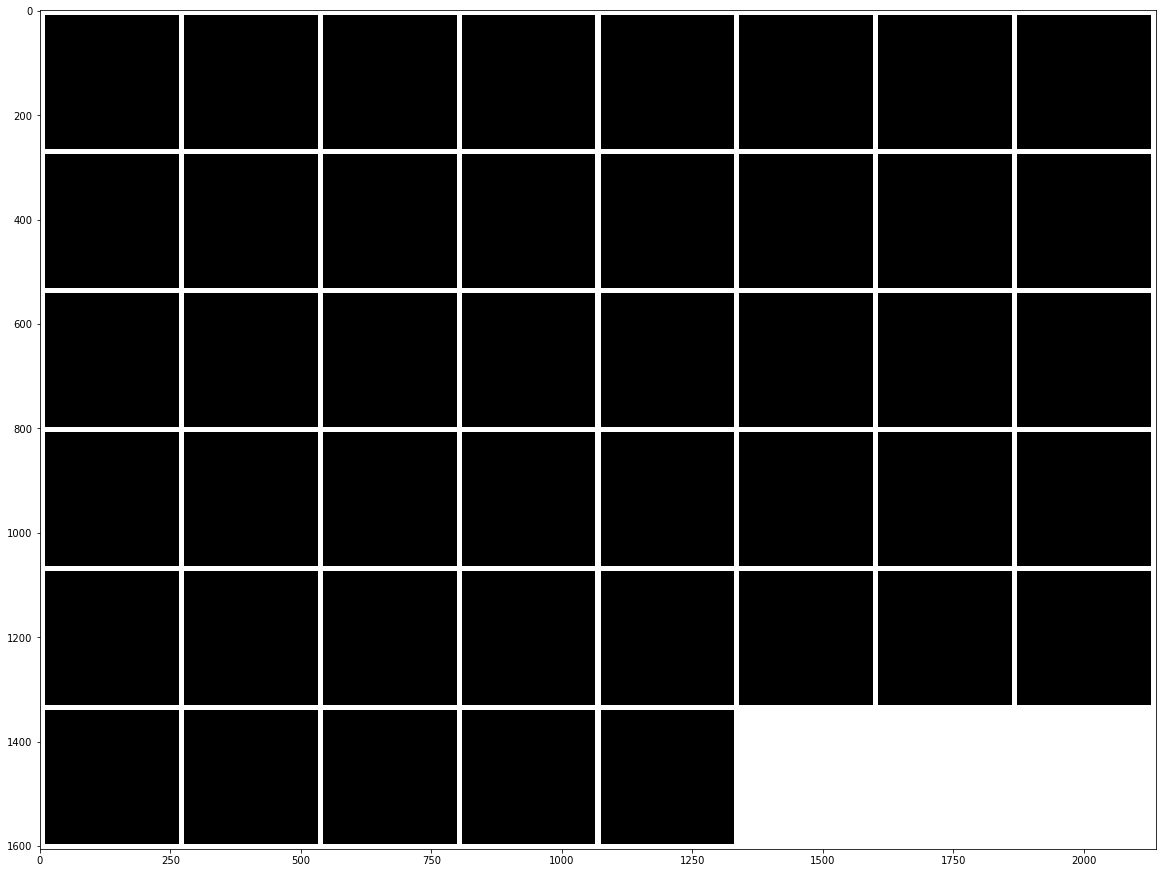

----------------------------------------------------------------------------------------------------
Prediction


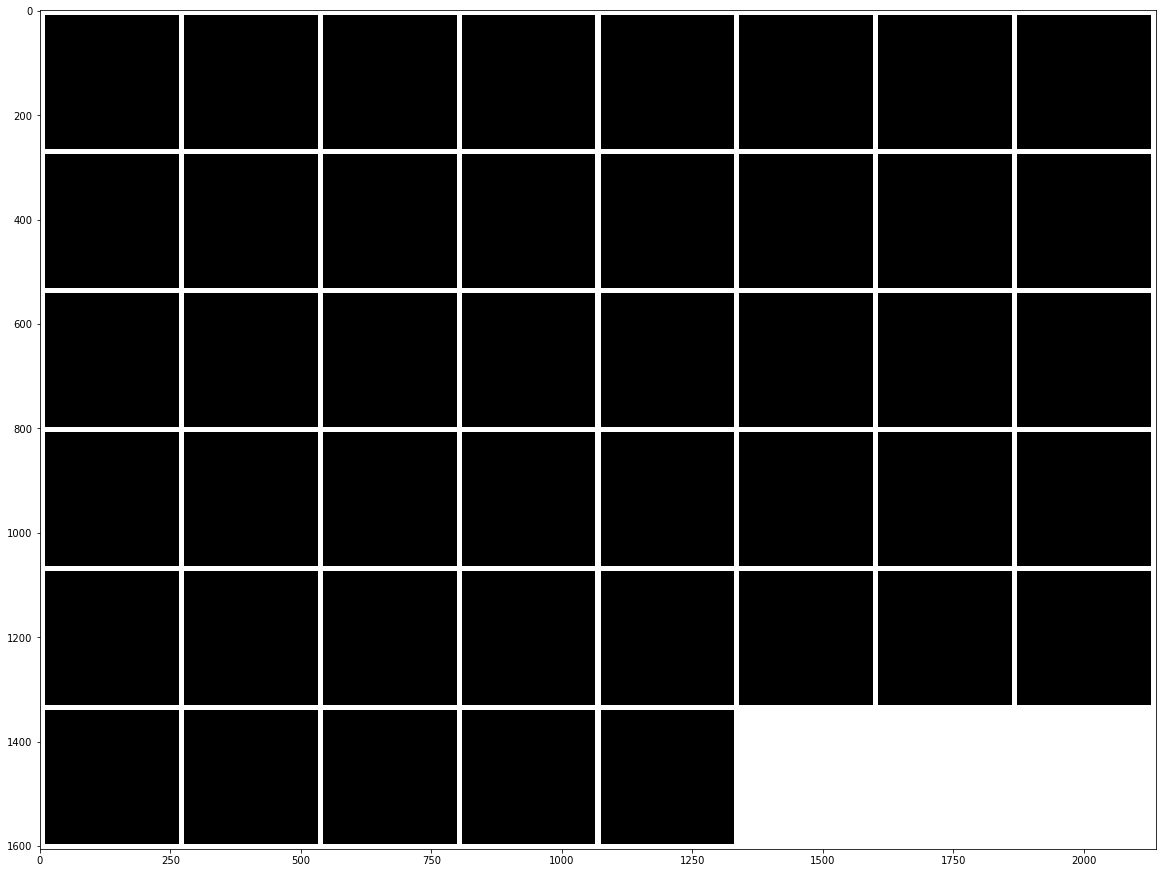

----------------------------------------------------------------------------------------------------
Ground Truth


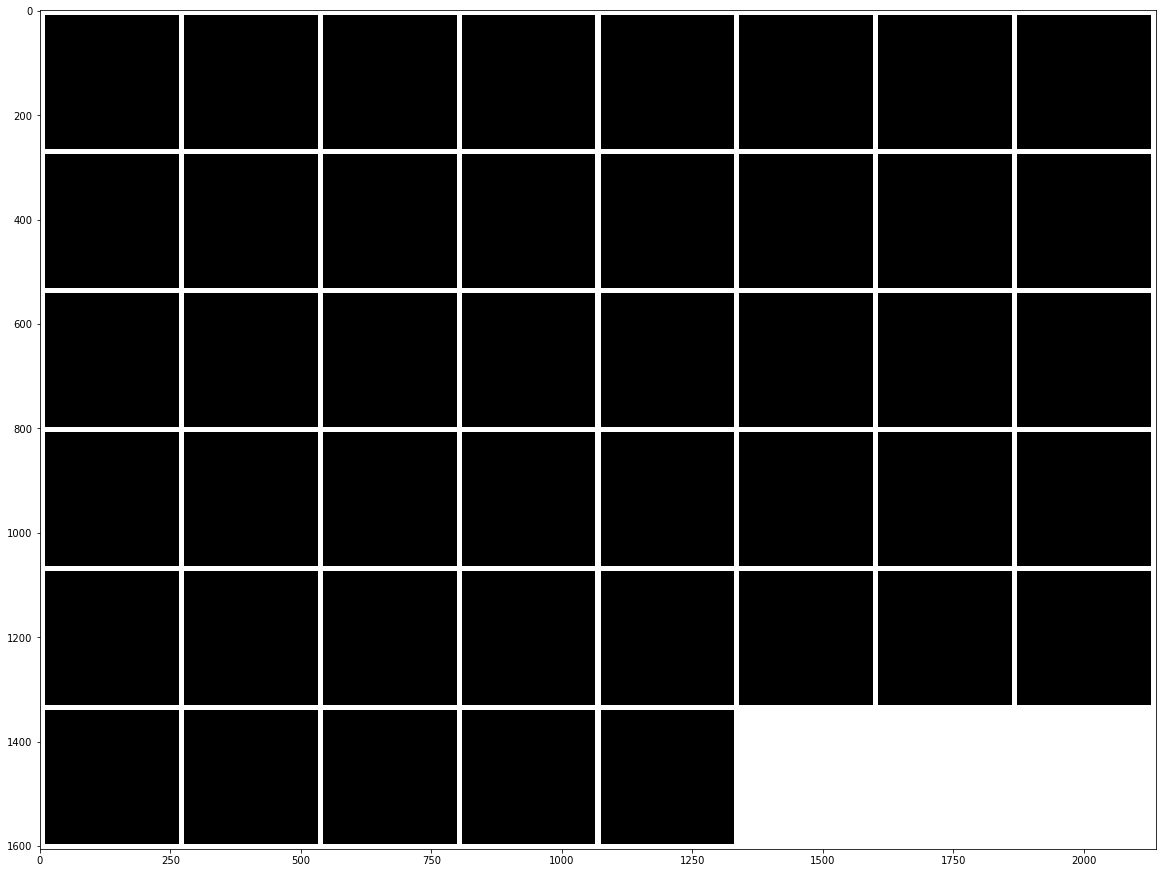

----------------------------------------------------------------------------------------------------
Prediction


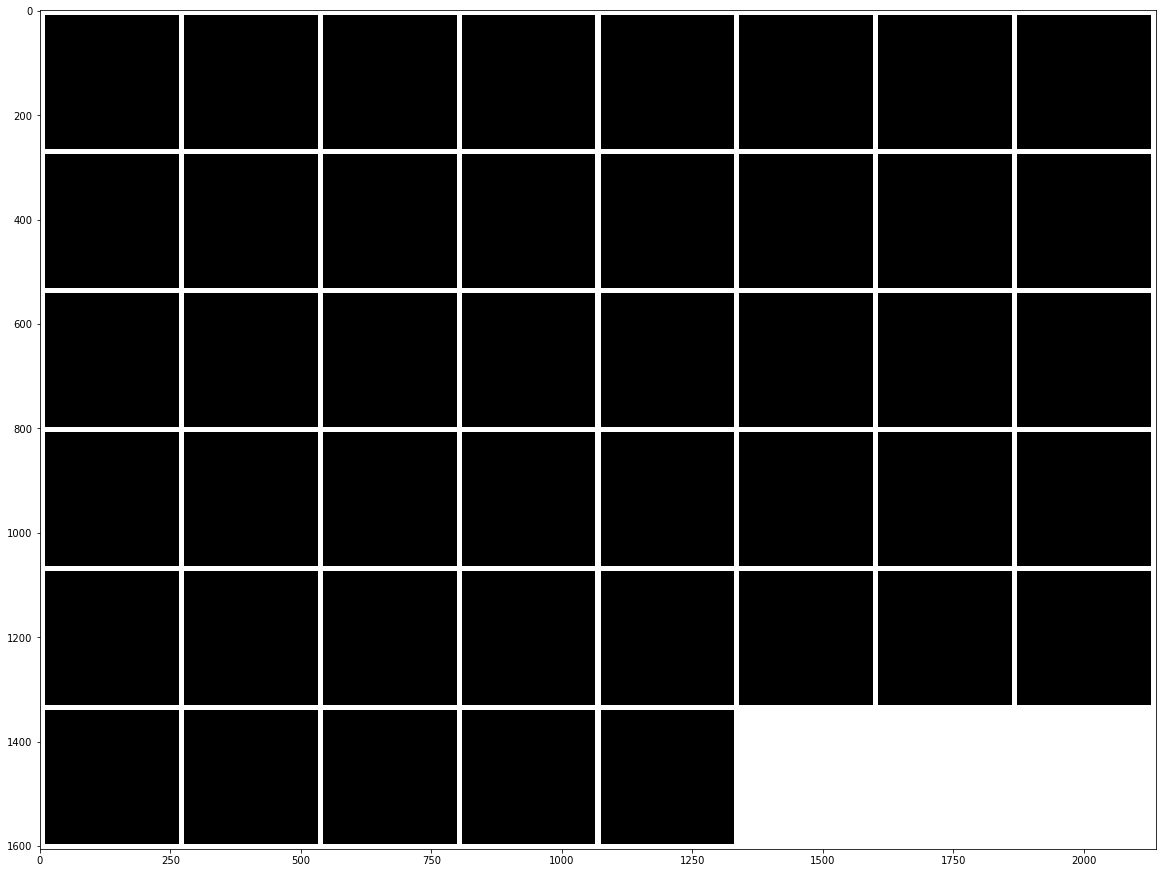

----------------------------------------------------------------------------------------------------
Ground Truth


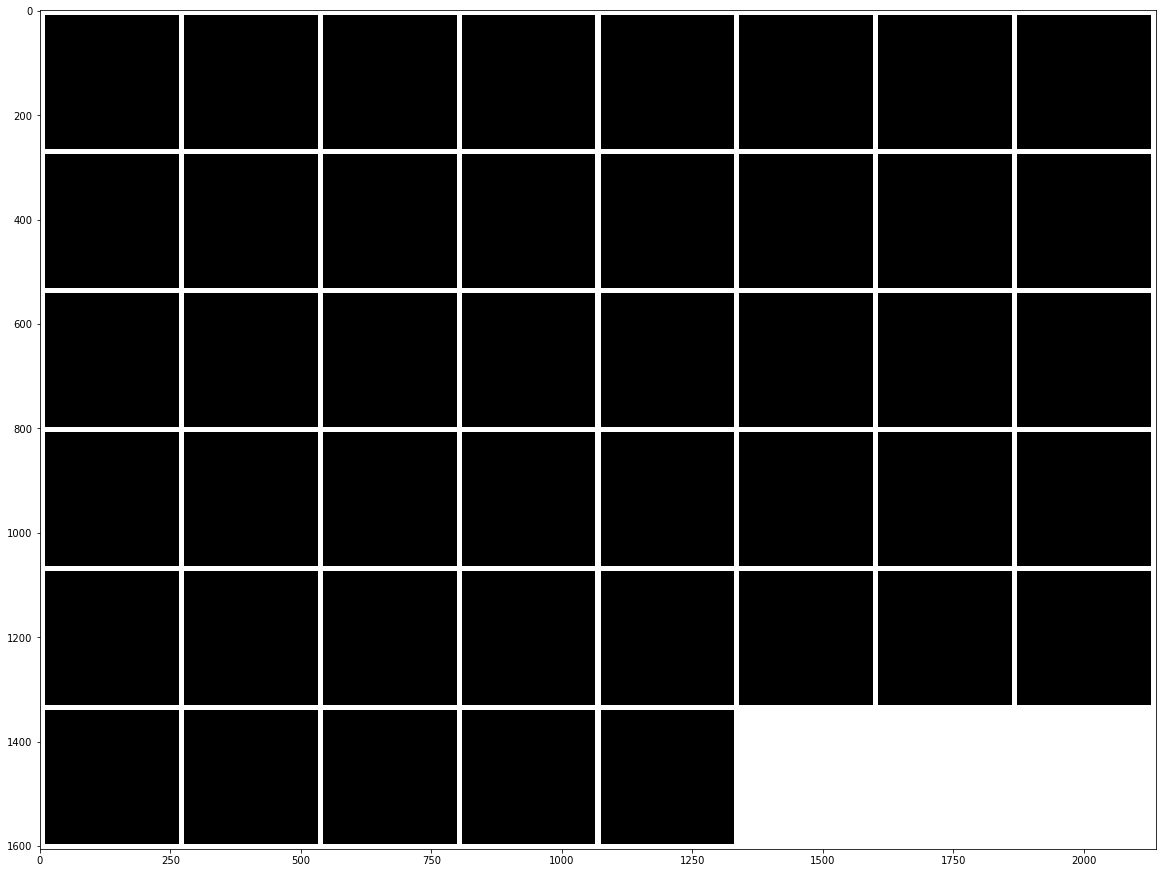

----------------------------------------------------------------------------------------------------
Prediction


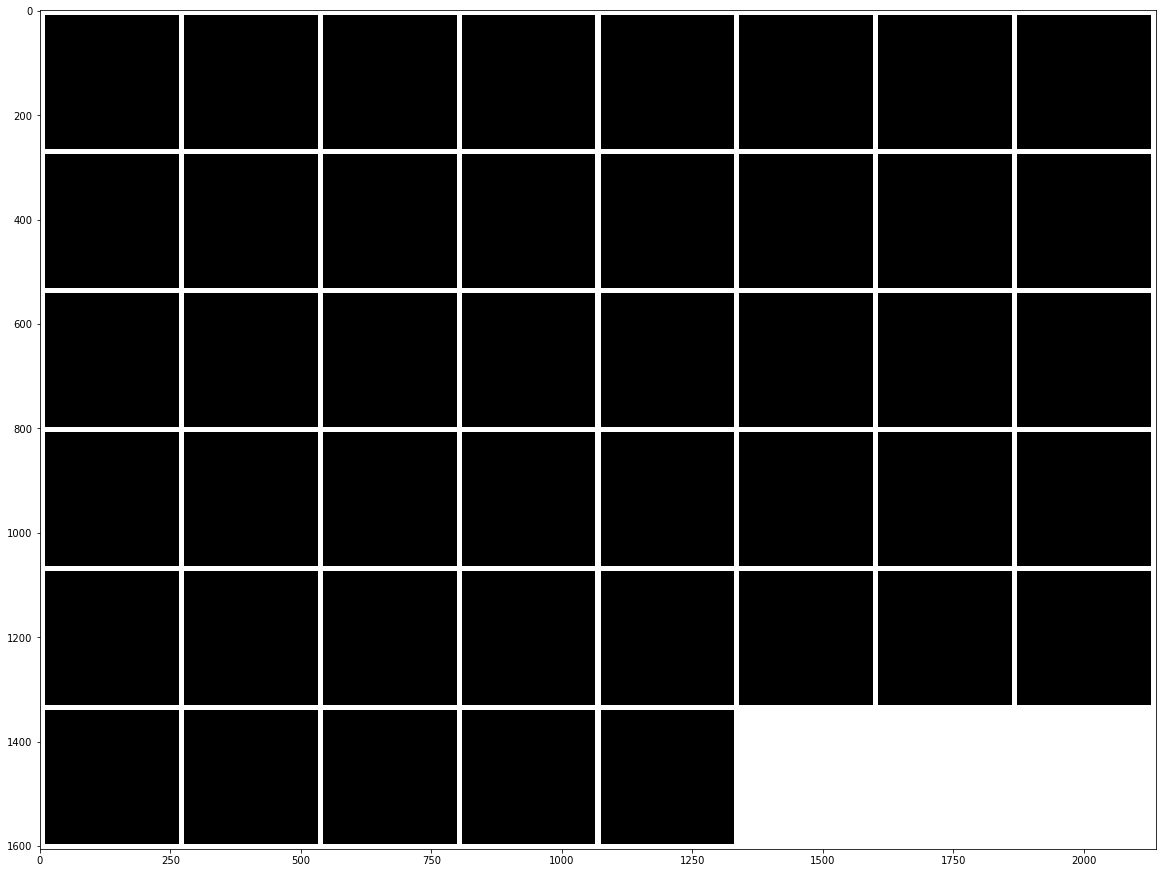

----------------------------------------------------------------------------------------------------
Ground Truth


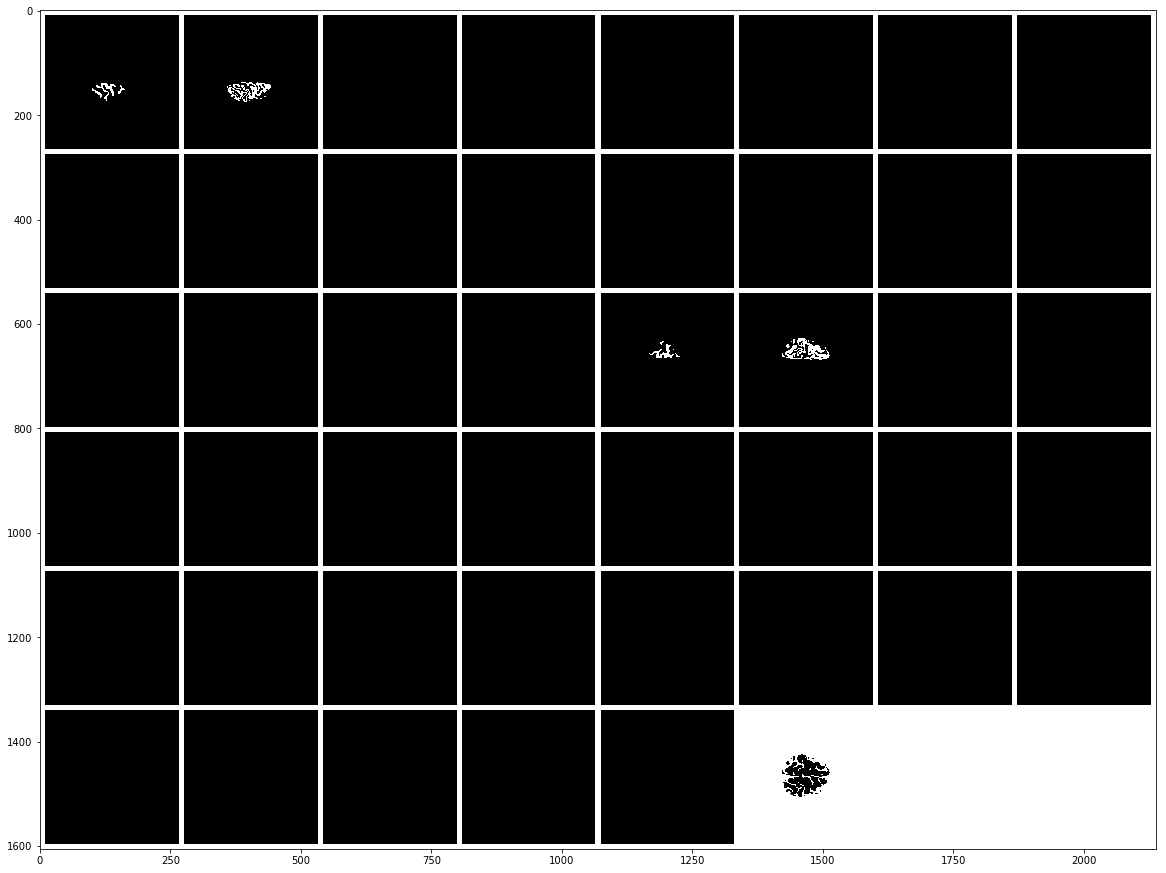

----------------------------------------------------------------------------------------------------
Prediction


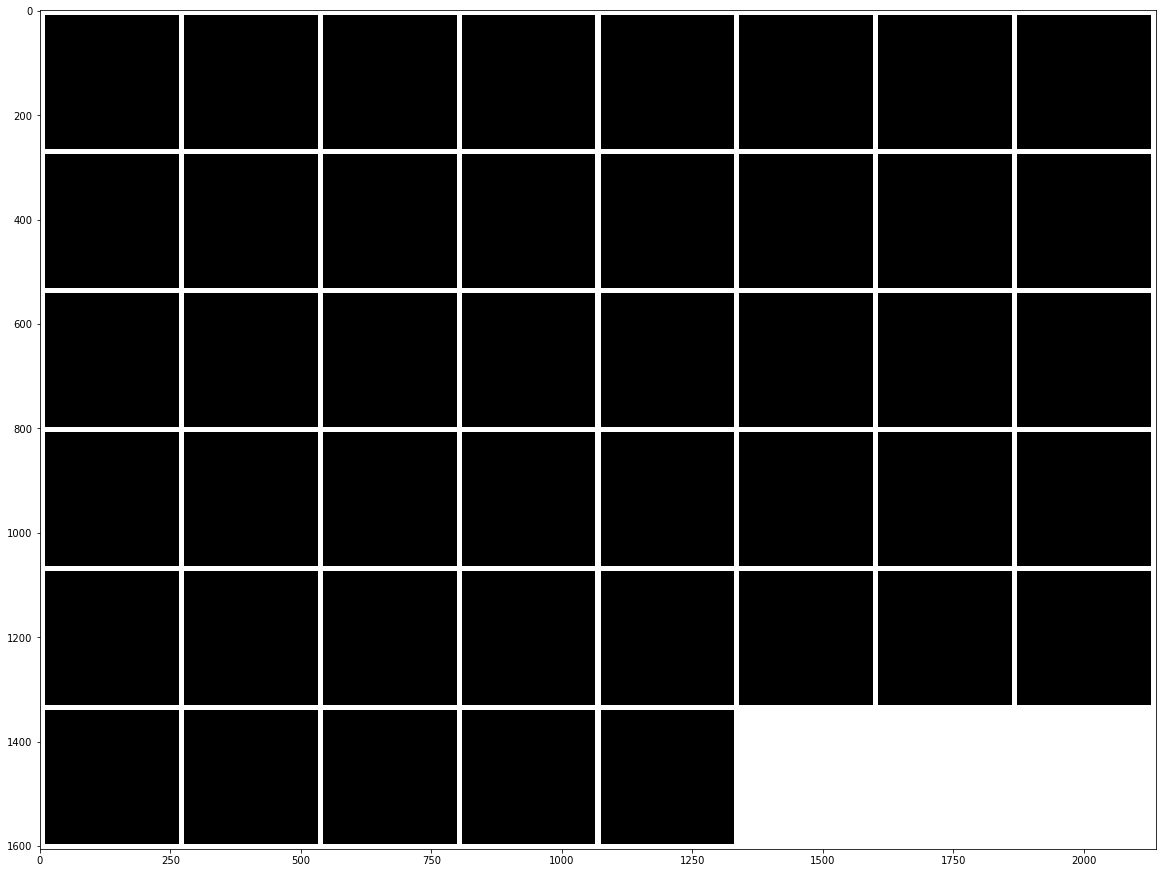

----------------------------------------------------------------------------------------------------
Ground Truth


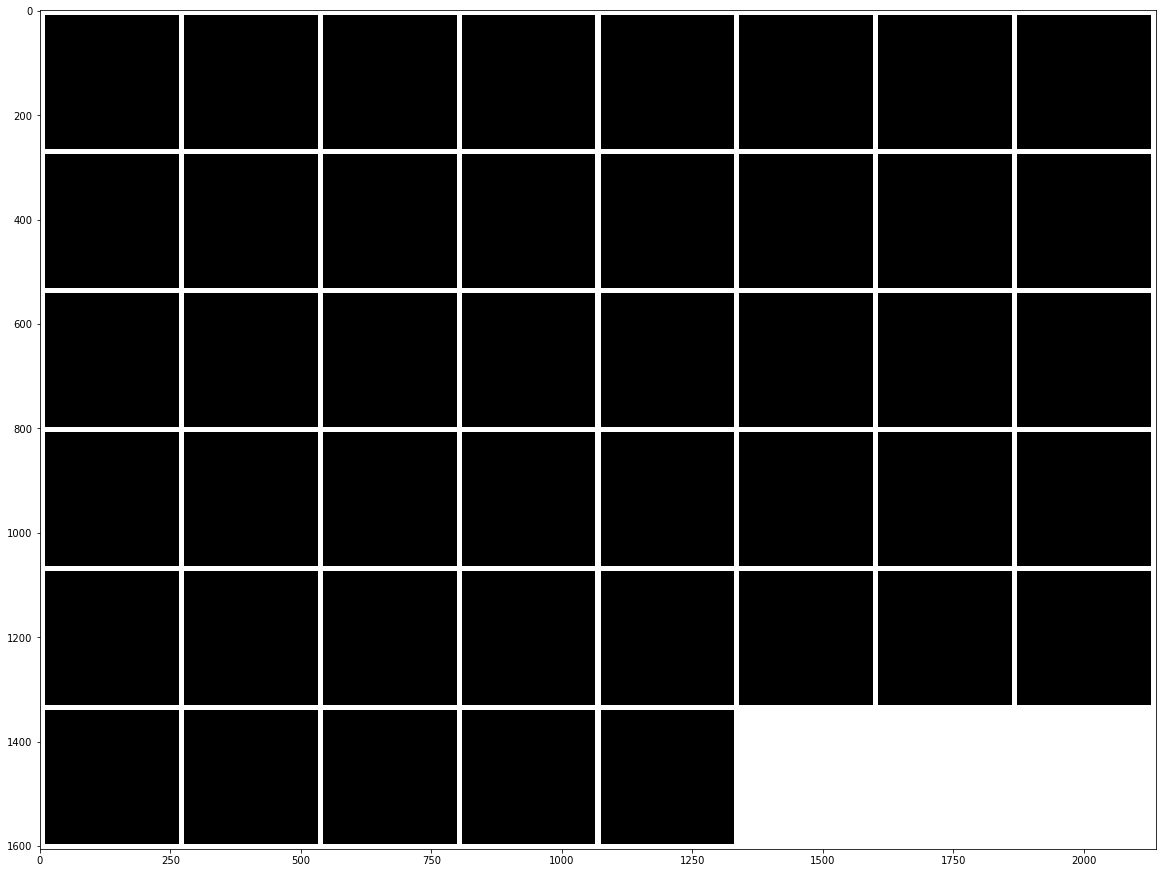

----------------------------------------------------------------------------------------------------
Prediction


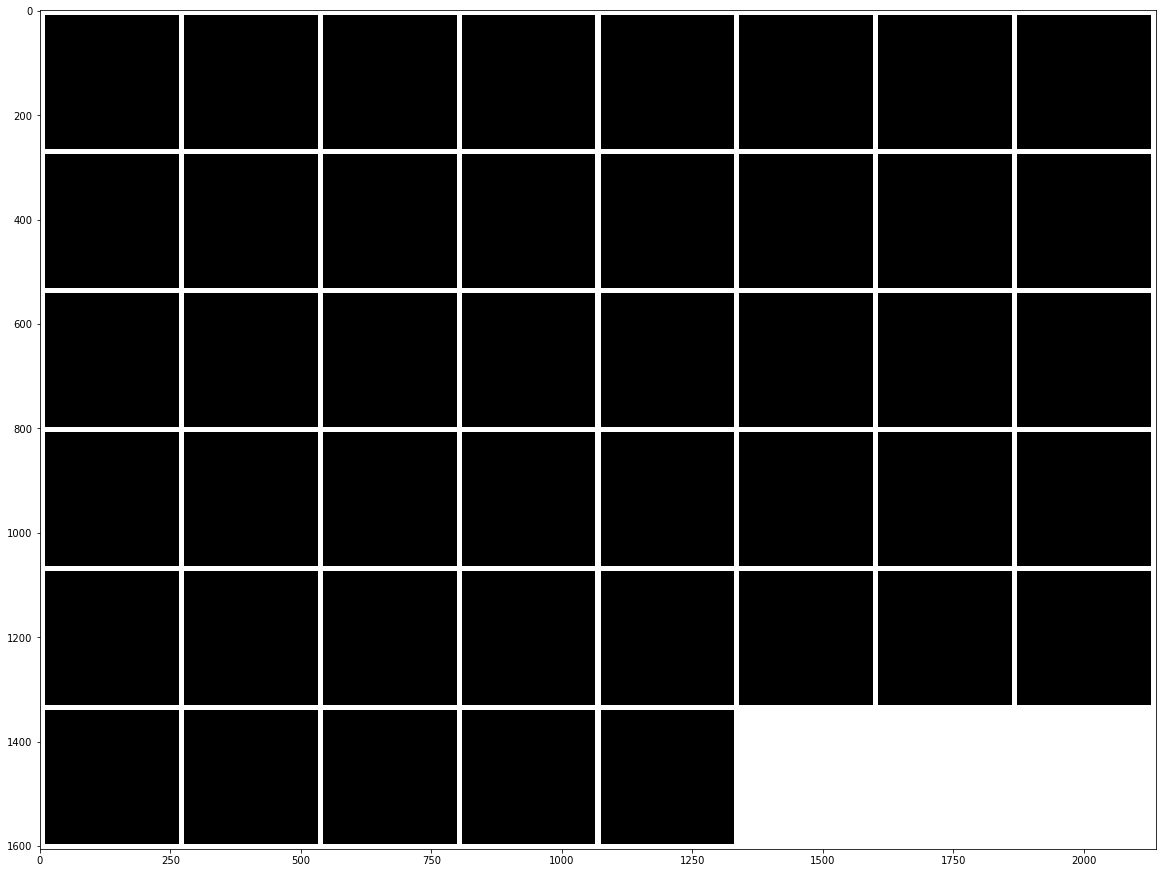

----------------------------------------------------------------------------------------------------
Ground Truth


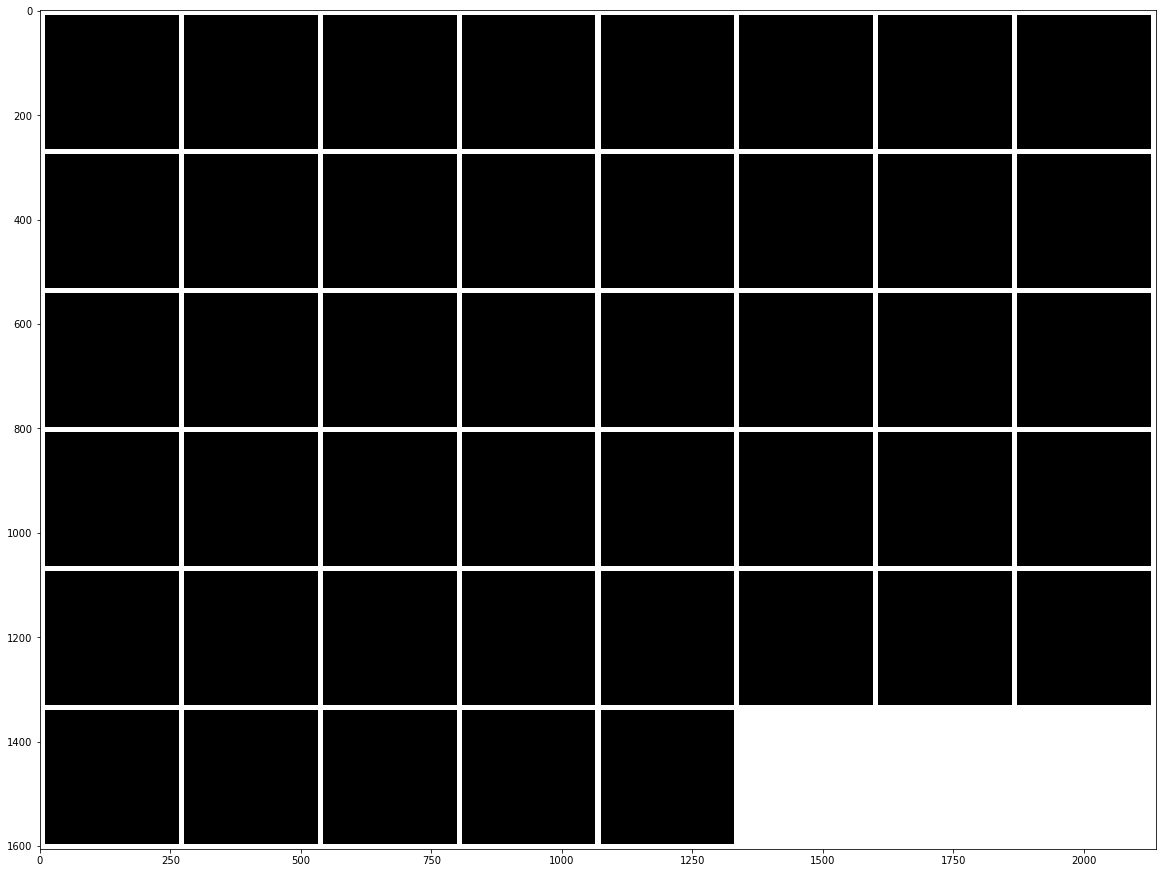

----------------------------------------------------------------------------------------------------
Prediction


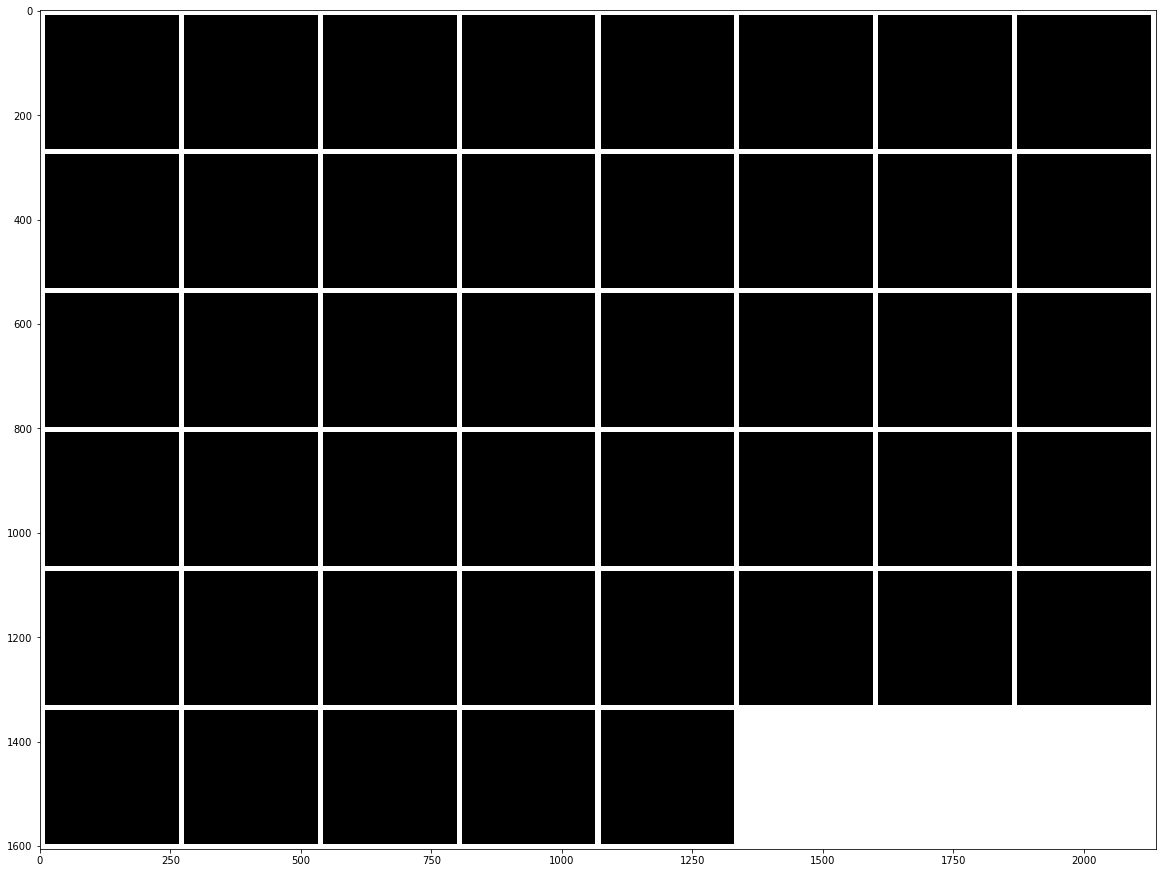

----------------------------------------------------------------------------------------------------
Ground Truth


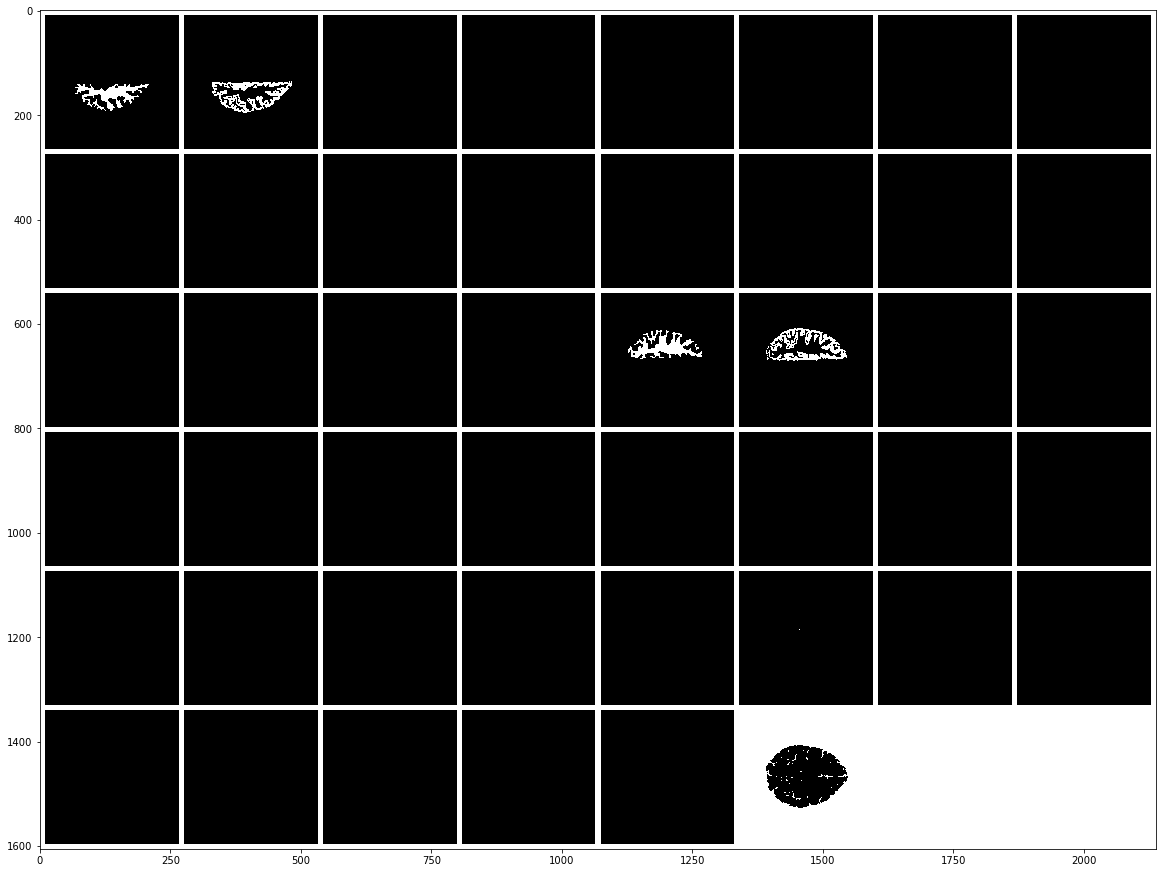

----------------------------------------------------------------------------------------------------
Prediction


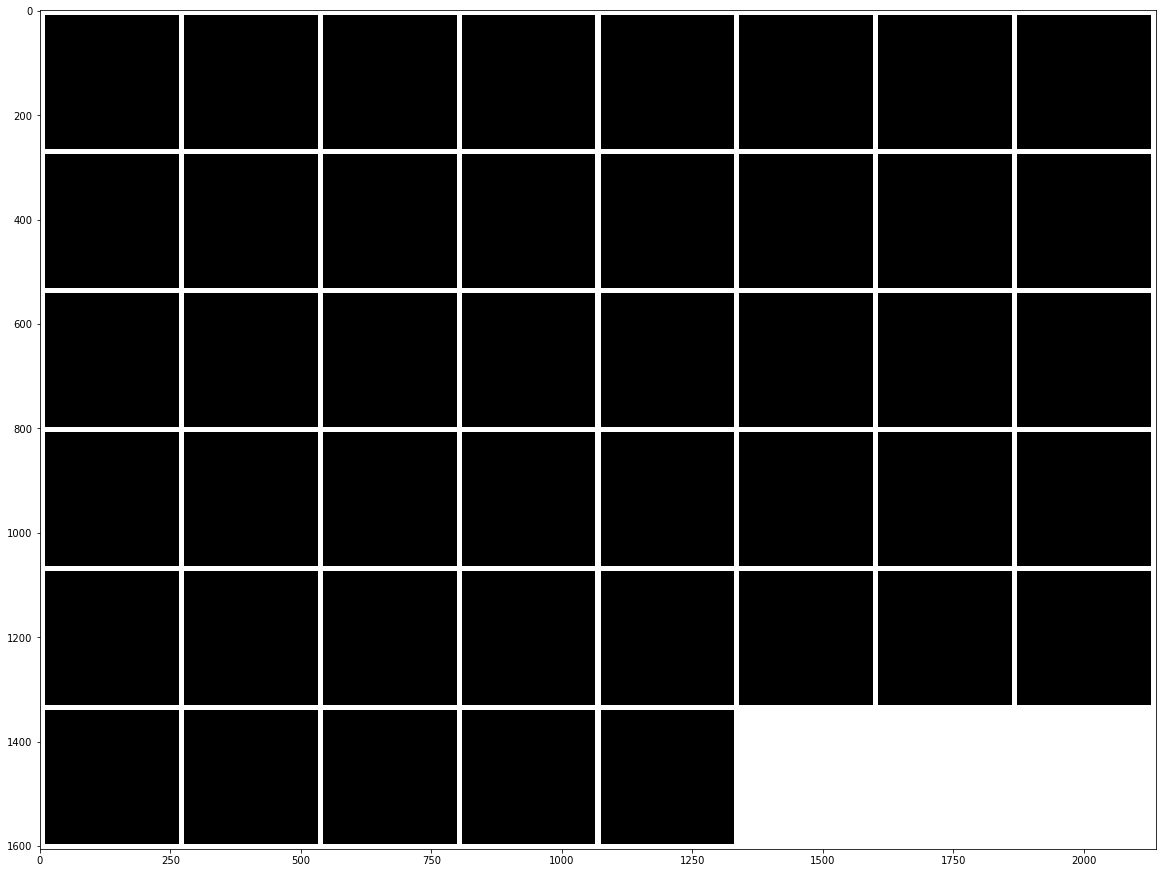

----------------------------------------------------------------------------------------------------
Ground Truth


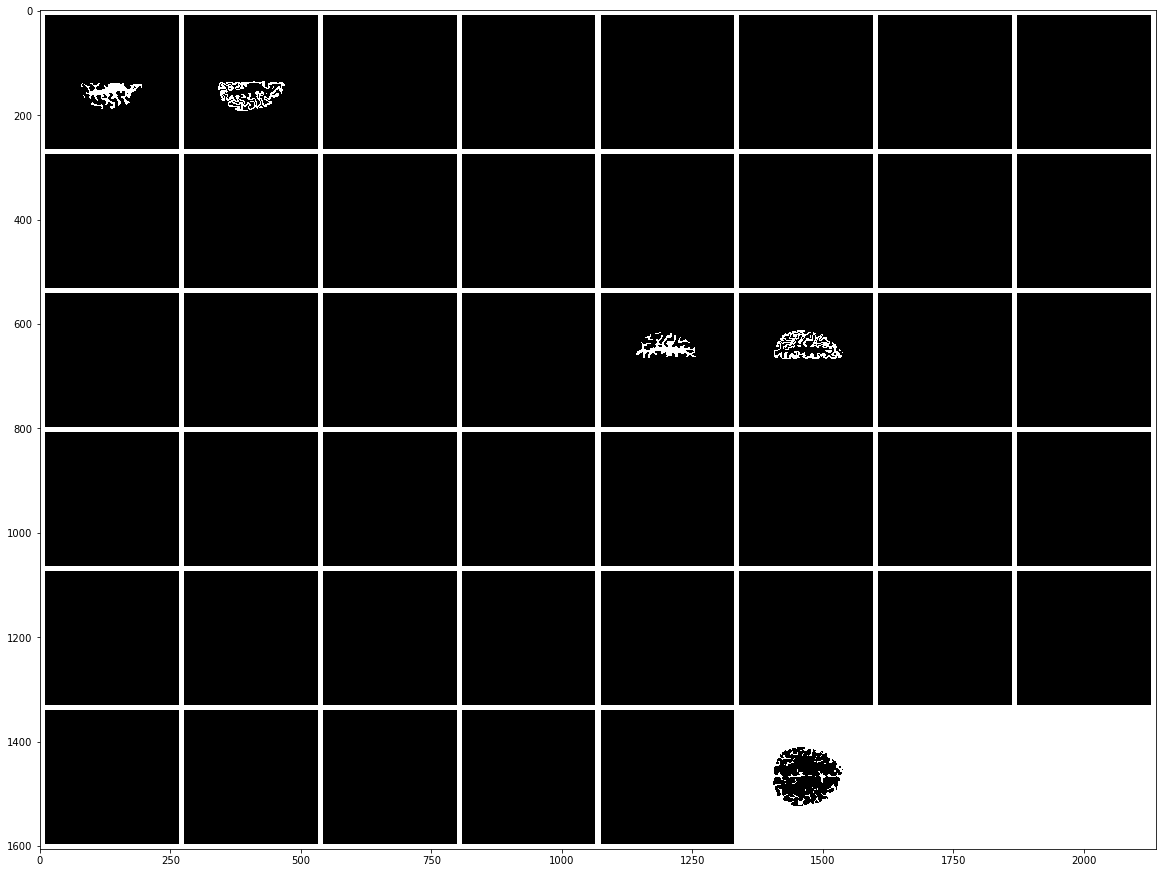

----------------------------------------------------------------------------------------------------
Prediction


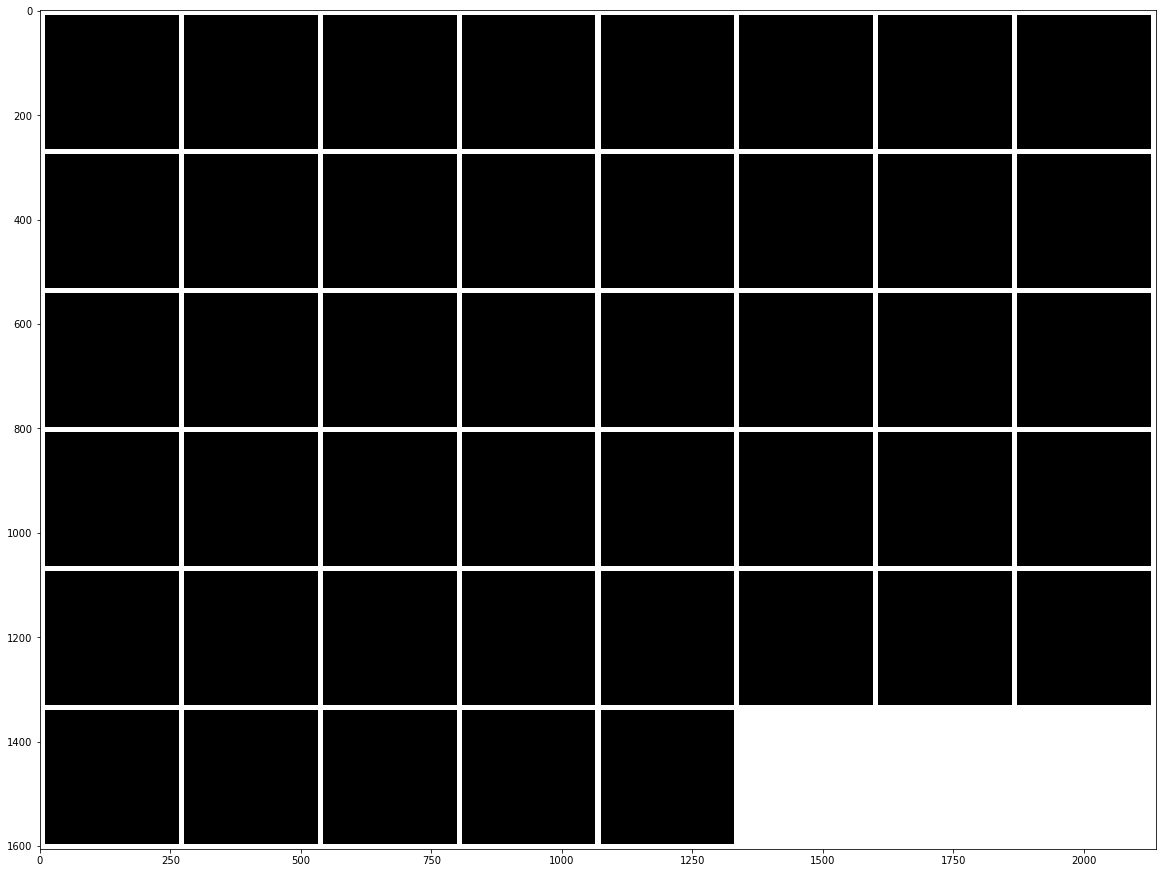

----------------------------------------------------------------------------------------------------
Ground Truth


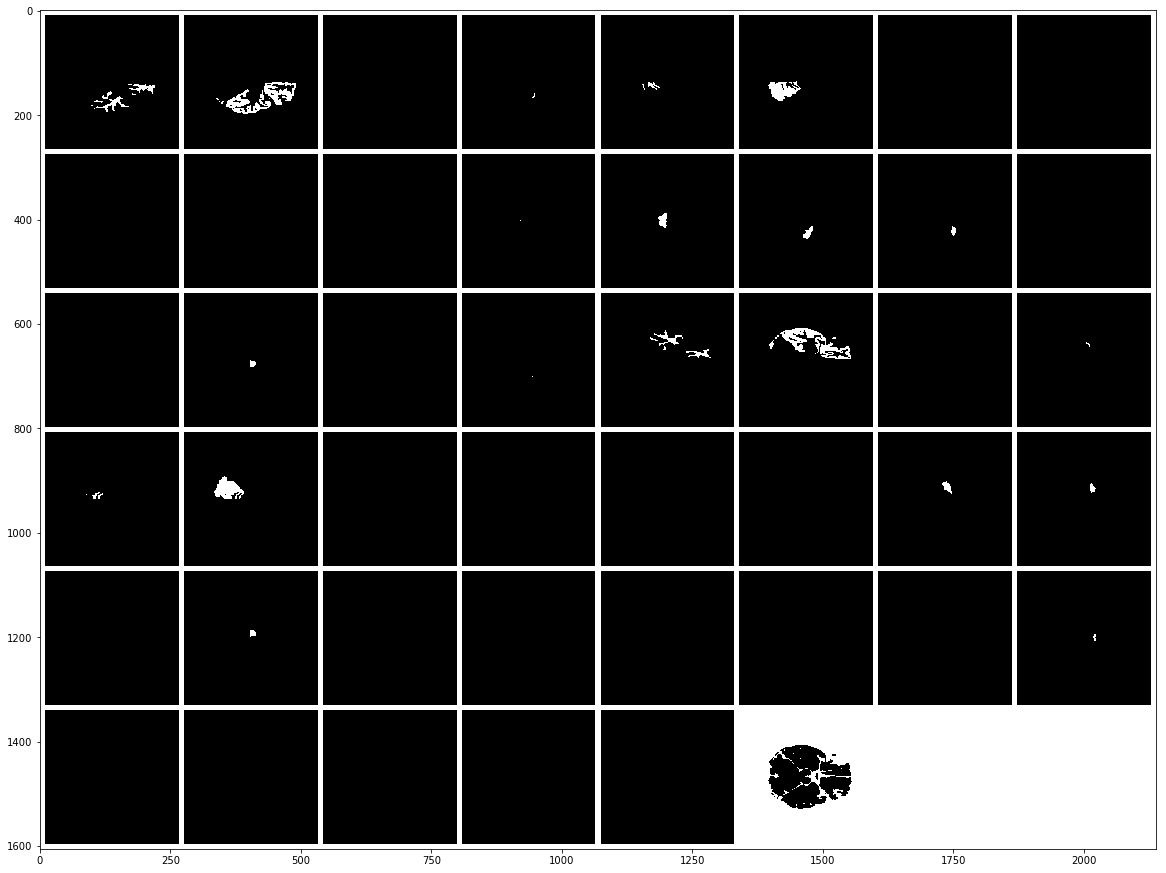

----------------------------------------------------------------------------------------------------
Prediction


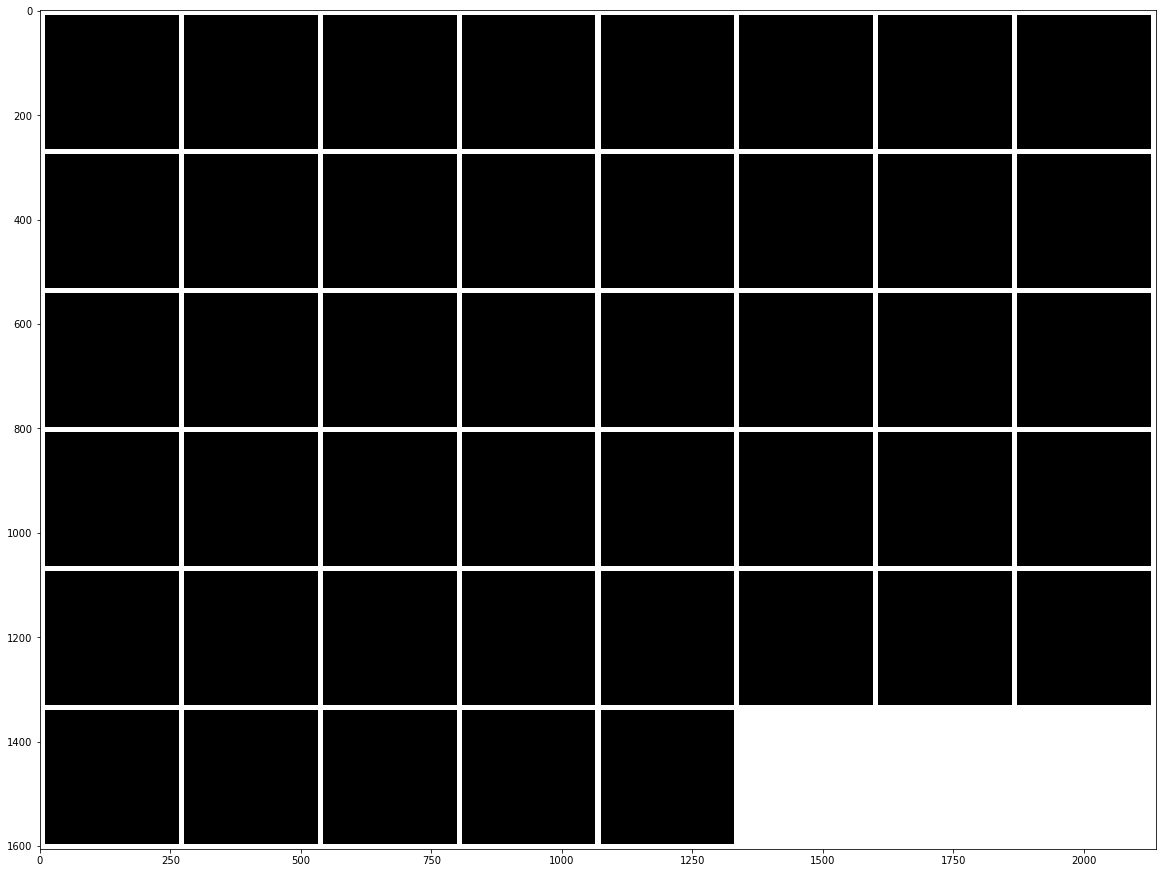

----------------------------------------------------------------------------------------------------
Ground Truth


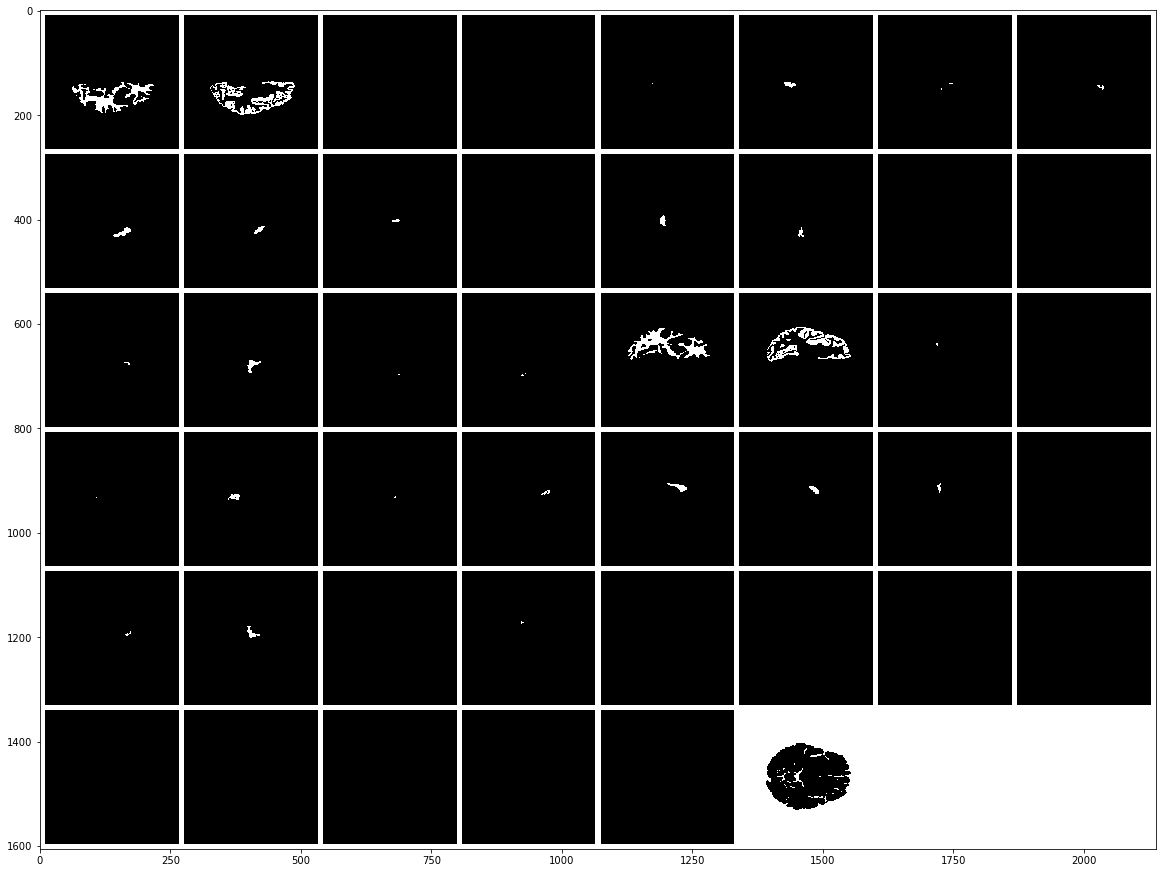

----------------------------------------------------------------------------------------------------
Prediction


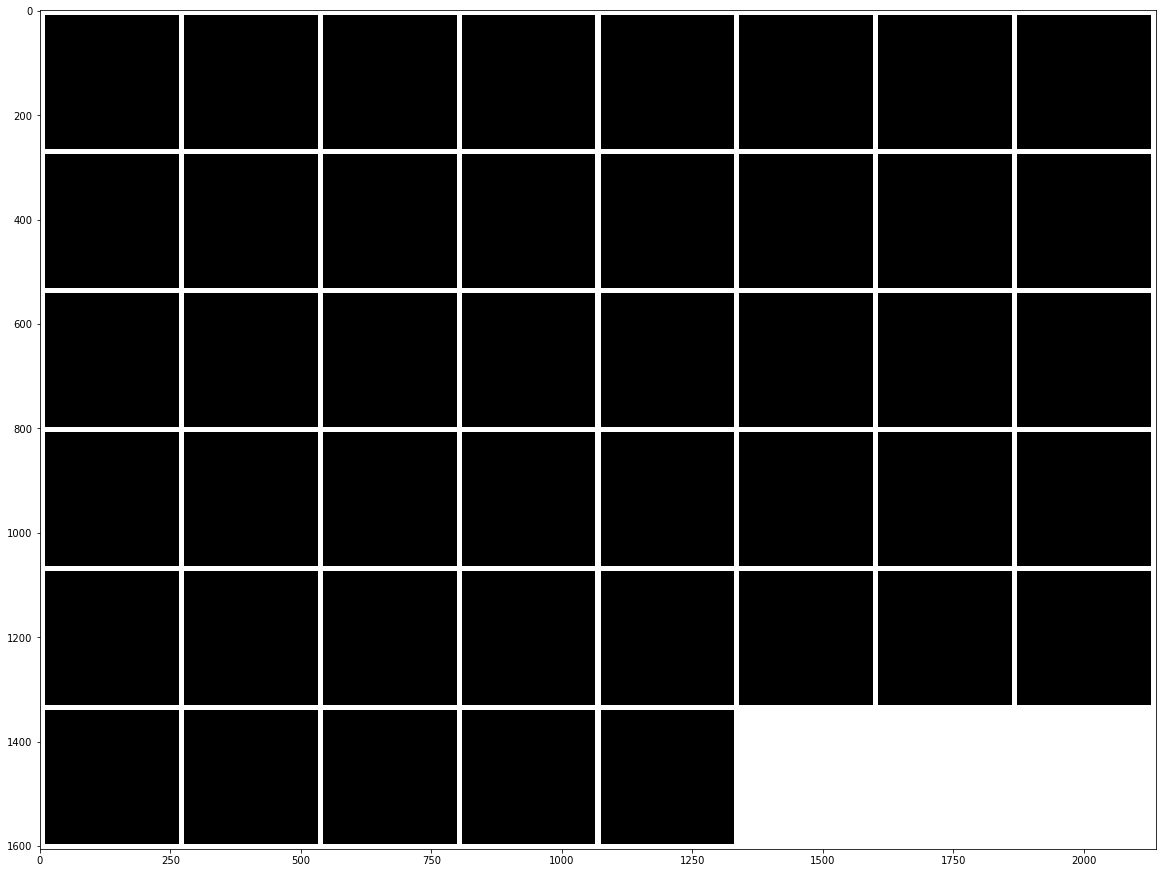

----------------------------------------------------------------------------------------------------
Ground Truth


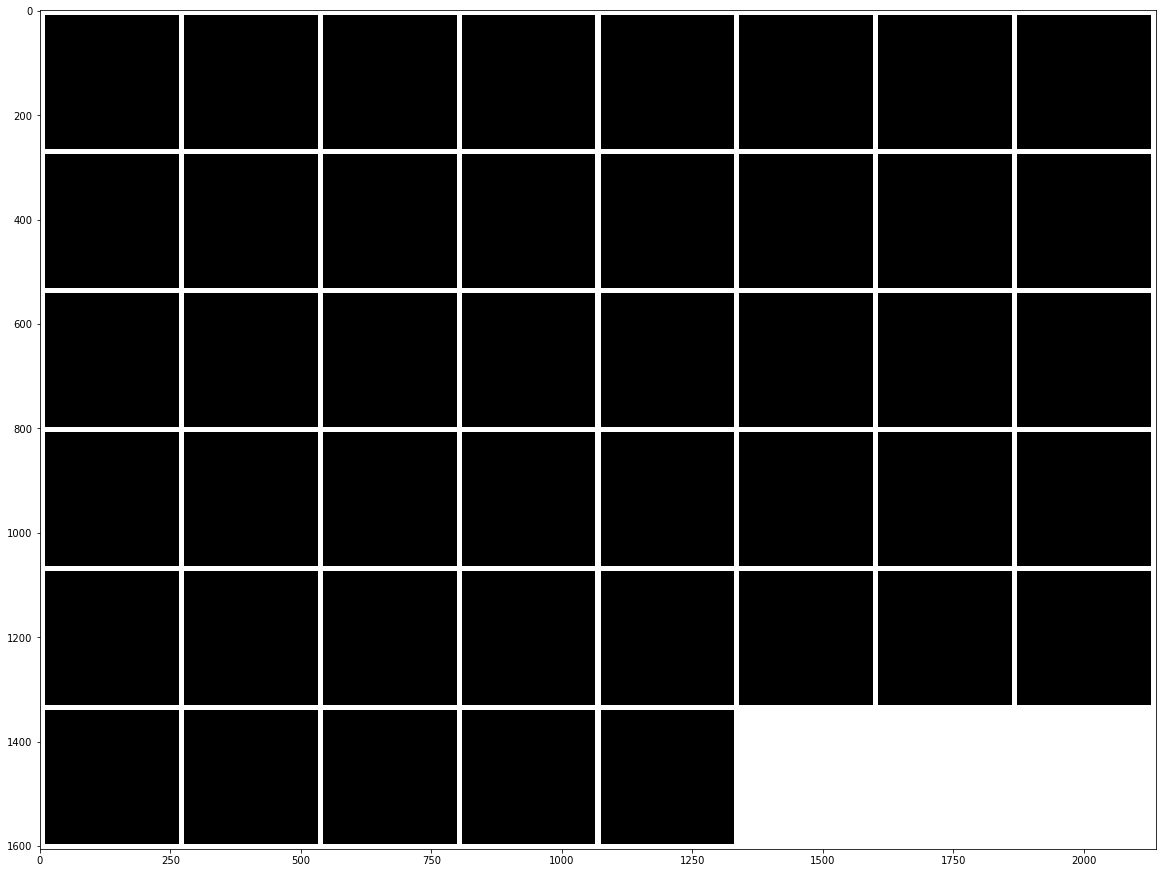

----------------------------------------------------------------------------------------------------
Prediction


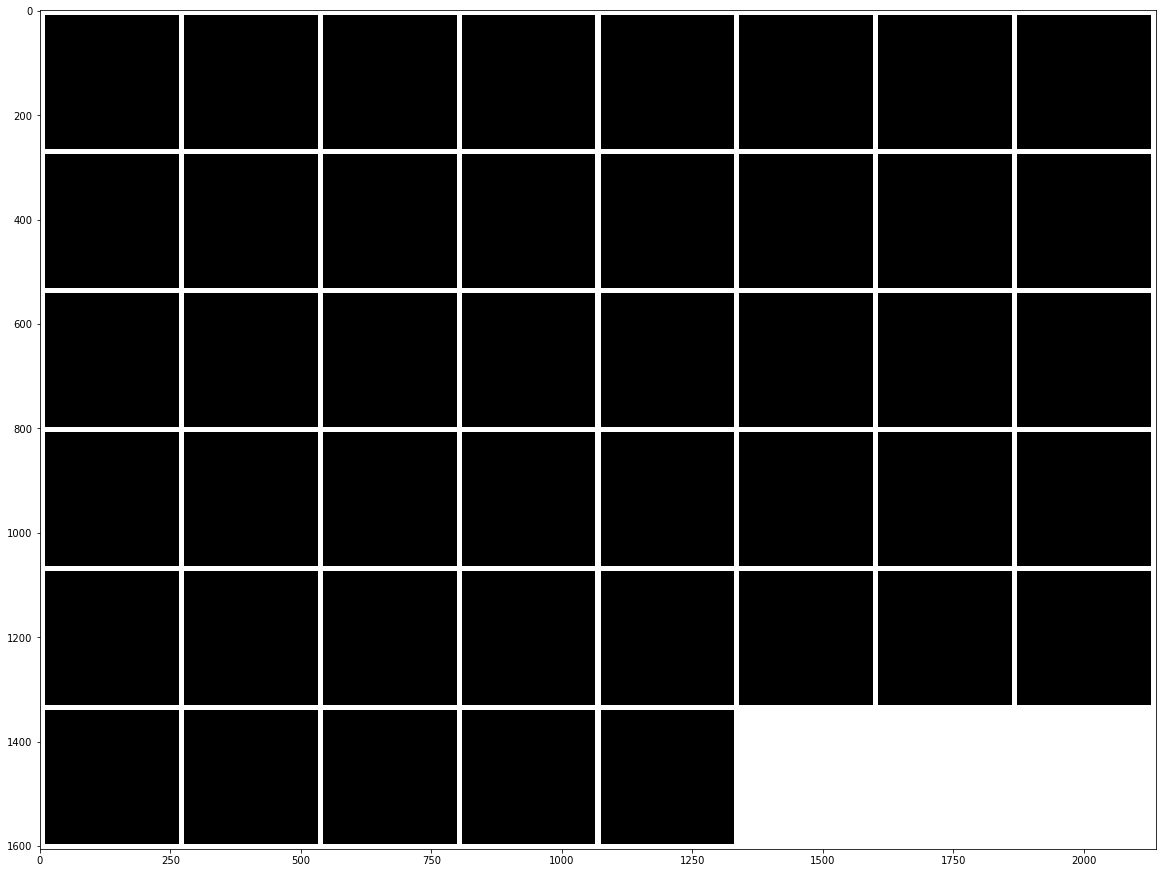

----------------------------------------------------------------------------------------------------
Ground Truth


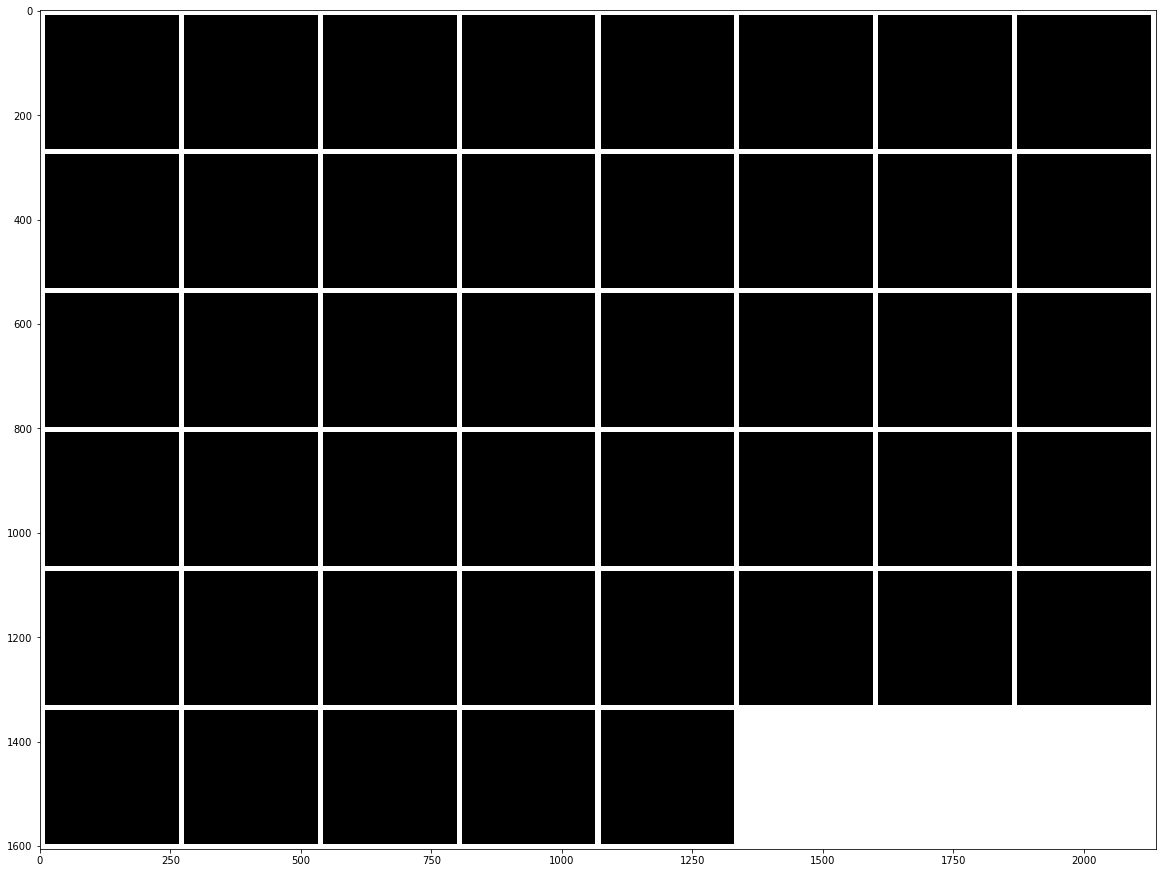

----------------------------------------------------------------------------------------------------
Prediction


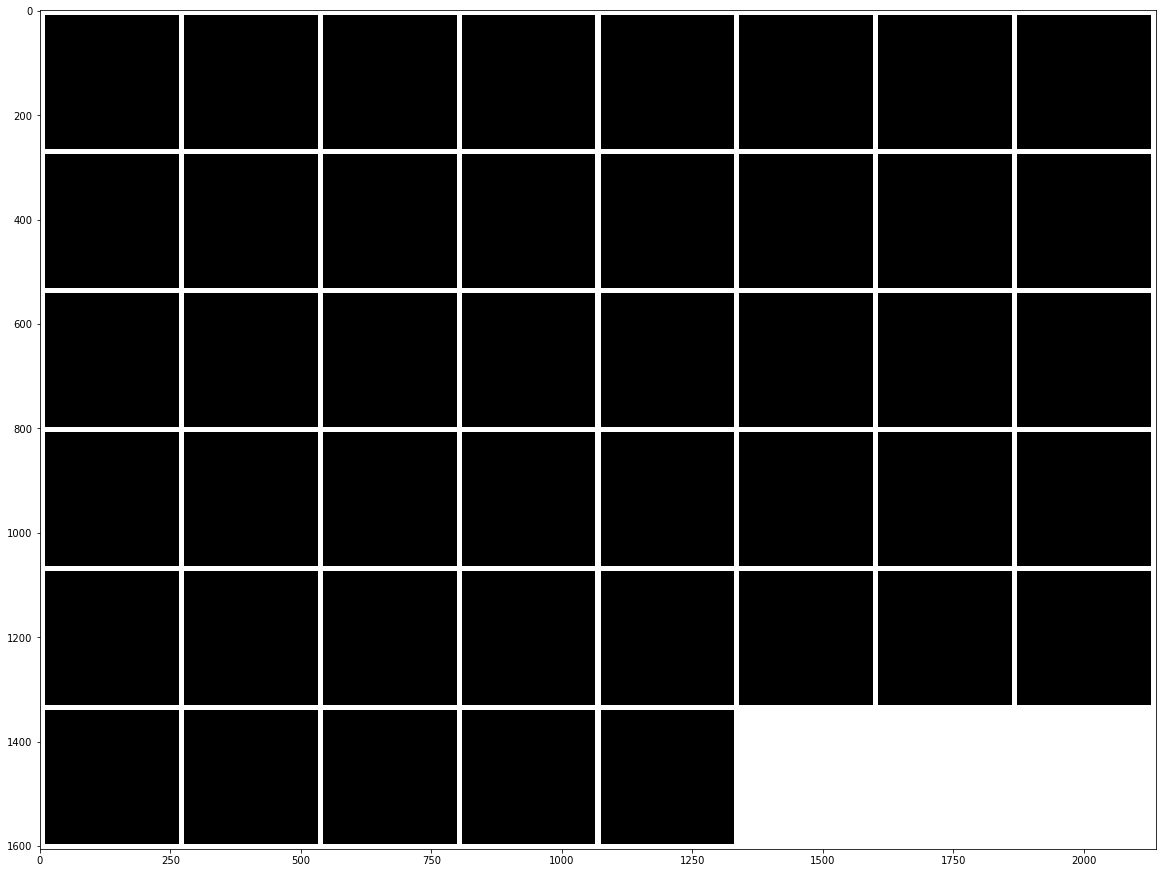

In [40]:
visualize_few()